# Postprocessing

Makes control plots and templates.

Authors: Raghav Kansal, Cristina Suarez

In [76]:
import os
from HH4b import utils, plotting, postprocessing
from HH4b.postprocessing import Region, weight_shifts
from HH4b.utils import ShapeVar, CUT_MAX_VAL
from HH4b.hh_vars import data_key, bg_keys, sig_keys, LUMI

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

from copy import deepcopy

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

In [77]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
MAIN_DIR = "../../../"
path_to_dir = f"{MAIN_DIR}/../data/skimmer/23Nov13_v9_private/"
year = "2018"

# make plot and template directory
date = "23Nov13_2018"
plot_dir = f"{MAIN_DIR}/plots/PostProcessing/{date}/{year}"
template_dir = f"templates/{date}/"
_ = os.system(f"mkdir -p {plot_dir}")
_ = os.system(f"mkdir -p {template_dir}/cutflows/{year}")

from HH4b.hh_vars import samples
samples = deepcopy(samples[year])
sig_keys = ["hh4b"]
for key in list(samples.keys()):
    if key not in bg_keys + sig_keys + [data_key]:
        del samples[key]

sample_dirs = {path_to_dir: samples}

In [79]:
sample_dirs

{'../../..//../data/skimmer/23Nov13_v9_private/': {'hh4b': ['GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8'],
  'qcd': ['QCD_HT-1000to1500-13TeV',
   'QCD_HT-1500to2000-13TeV',
   'QCD_HT-2000toInf-13TeV',
   'QCD_HT-200to300-13TeV',
   'QCD_HT-300to500-13TeV',
   'QCD_HT-500to700-13TeV',
   'QCD_HT-700to1000-13TeV'],
  'data': ['Run2018A', 'Run2018B', 'Run2018C', 'Run2018D'],
  'ttbar': ['TTTo2L2Nu_13TeV', 'TTToHadronic_13TeV', 'TTToSemiLeptonic_13TeV'],
  'vjets': ['WJetsToQQ_HT-200to400_13TeV',
   'WJetsToQQ_HT-400to600_13TeV',
   'WJetsToQQ_HT-600to800_13TeV',
   'WJetsToQQ_HT-800toInf_13TeV',
   'ZJetsToQQ_HT-200to400_13TeV',
   'ZJetsToQQ_HT-400to600_13TeV',
   'ZJetsToQQ_HT-600to800_13TeV',
   'ZJetsToQQ_HT-800toInf_13TeV'],
  'diboson': ['ZZTo4B01j_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8'],
  'gghtobb': ['GluGluHToBB_M-125_TuneCP5_MINLO_NNLOPS_13TeV-powheg-pythia8'],
  'vbfhtobb': ['VBFHToBB_M-125_dipoleRecoilOn_TuneCP5_13TeV-powheg-pythia8'],
  'vhtobb': ['WminusH_

In [107]:
df = pd.read_parquet("../../../../data/skimmer/23Nov13_v9_private/2018/Run2018A/parquet")
list(df.columns)


[('ak4JetEta', 0),
 ('ak4JetEta', 1),
 ('ak4JetEta', 2),
 ('ak4JetEta', 3),
 ('ak4JetEta', 4),
 ('ak4JetEta', 5),
 ('ak4JetPhi', 0),
 ('ak4JetPhi', 1),
 ('ak4JetPhi', 2),
 ('ak4JetPhi', 3),
 ('ak4JetPhi', 4),
 ('ak4JetPhi', 5),
 ('ak4JetMass', 0),
 ('ak4JetMass', 1),
 ('ak4JetMass', 2),
 ('ak4JetMass', 3),
 ('ak4JetMass', 4),
 ('ak4JetMass', 5),
 ('ak4JetPt', 0),
 ('ak4JetPt', 1),
 ('ak4JetPt', 2),
 ('ak4JetPt', 3),
 ('ak4JetPt', 4),
 ('ak4JetPt', 5),
 ('ak8FatJetEta', 0),
 ('ak8FatJetEta', 1),
 ('ak8FatJetPhi', 0),
 ('ak8FatJetPhi', 1),
 ('ak8FatJetMass', 0),
 ('ak8FatJetMass', 1),
 ('ak8FatJetPt', 0),
 ('ak8FatJetPt', 1),
 ('ak8FatJetMsd', 0),
 ('ak8FatJetMsd', 1),
 ('ak8FatJetPNetXbb', 0),
 ('ak8FatJetPNetXbb', 1),
 ('ak8FatJetPNetXjj', 0),
 ('ak8FatJetPNetXjj', 1),
 ('ak8FatJetPNetMass', 0),
 ('ak8FatJetPNetMass', 1),
 ('event', 0),
 ('run', 0),
 ('ht', 0),
 ('nJets', 0),
 ('nFatJets', 0),
 ('nPU', 0),
 ('nPV', 0),
 ('PFJet500', 0),
 ('AK8PFJet500', 0),
 ('AK8PFJet360_TrimMass30', 

In [81]:
filters = [
    [
        ("('ak8FatJetPt', '0')", ">=", 300),
        ("('ak8FatJetPt', '1')", ">=", 300),
        ("('ak8FatJetMsd', '0')", ">=", 60),
        ("('ak8FatJetMsd', '1')", ">=", 60),
    ],
]

# save cutflow as pandas table
cutflow = pd.DataFrame(index=list(samples.keys()))

# dictionary that will contain all information (from all samples)
events_dict = {}
for input_dir, samples in sample_dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(
            input_dir,
            samples,
            year,
            filters=filters,
            columns=utils.format_columns(load_columns),
        ),
    }

utils.add_to_cutflow(events_dict, "Preselection", "weight", cutflow)
print("\n", cutflow)

Loading GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8
Loading QCD_HT-200to300-13TeV
Loading QCD_HT-1000to1500-13TeV
Loading QCD_HT-500to700-13TeV
Loading QCD_HT-700to1000-13TeV
Loading QCD_HT-300to500-13TeV
Loading QCD_HT-1500to2000-13TeV
Loading QCD_HT-2000toInf-13TeV
Loading Run2018A
Loading Run2018C
Loading Run2018D
Loading Run2018B
Loading TTToHadronic_13TeV
Loading TTToSemiLeptonic_13TeV
Loading TTTo2L2Nu_13TeV
Loading ZJetsToQQ_HT-400to600_13TeV
Loading WJetsToQQ_HT-600to800_13TeV
Loading WJetsToQQ_HT-800toInf_13TeV
Loading WJetsToQQ_HT-200to400_13TeV
Loading ZJetsToQQ_HT-200to400_13TeV
Loading ZJetsToQQ_HT-800toInf_13TeV
Loading ZJetsToQQ_HT-600to800_13TeV
Loading WJetsToQQ_HT-400to600_13TeV


Loading ZZTo4B01j_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8
Loading GluGluHToBB_M-125_TuneCP5_MINLO_NNLOPS_13TeV-powheg-pythia8
Loading VBFHToBB_M-125_dipoleRecoilOn_TuneCP5_13TeV-powheg-pythia8
Loading WplusH_HToBB_WToQQ_M-125_TuneCP5_13TeV-powheg-pythia8
Loading ZH_HToBB_ZToQQ_M-125_TuneCP5_13TeV-powheg-pythia8
Loading WminusH_HToBB_WToQQ_M-125_TuneCP5_13TeV-powheg-pythia8
Loading ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8

           Preselection
hh4b      3.774126e+00
qcd       1.287102e+07
data      1.083465e+07
ttbar     1.851479e+05
vjets     2.179795e+05
diboson   2.205277e+01
gghtobb   2.004560e-04
vbfhtobb  4.192265e+01
vhtobb    1.828203e+02
tthtobb   3.840251e+02


In [82]:
bb_masks = postprocessing.bb_assignment(events_dict)
bb_masks

{'hh4b':            0      1
 0       True  False
 1       True  False
 2      False   True
 3      False   True
 4       True  False
 ...      ...    ...
 13774  False   True
 13775   True  False
 13776  False   True
 13777   True  False
 13778   True  False
 
 [13779 rows x 2 columns],
 'qcd':             0      1
 0        True  False
 1        True  False
 2       False   True
 3        True  False
 4        True  False
 ...       ...    ...
 763713   True  False
 763714   True  False
 763715  False   True
 763716  False   True
 763717  False   True
 
 [5284421 rows x 2 columns],
 'data':              0      1
 0         True  False
 1        False   True
 2         True  False
 3         True  False
 4         True  False
 ...        ...    ...
 1174777  False   True
 1174778  False   True
 1174779  False   True
 1174780   True  False
 1174781   True  False
 
 [10834649 rows x 2 columns],
 'ttbar':            0      1
 0      False   True
 1      False   True
 2      False   True


### Control Plots

                    ┌────────────────────────────────────────────────────────┐
[-inf,  300) 0      │                                                        │
[ 300,  324) 0.2101 │                                                        │
[ 324,  348) 0.2824 │                                                        │
[ 348,  372) 0.4046 │                                                        │
[ 372,  396) 0.5353 │                                                        │
[ 396,  420) 0.3874 │                                                        │
[ 420,  444) 0.8291 │                                                        │
[ 444,  468) 0.8835 │                                                        │
[ 468,  492) 0.9331 │                                                        │
[ 492,  516) 0.9104 │                                                        │
[ 516,  540) 0.8936 │                                                        │
[ 540,  564) 0.8972 │                               

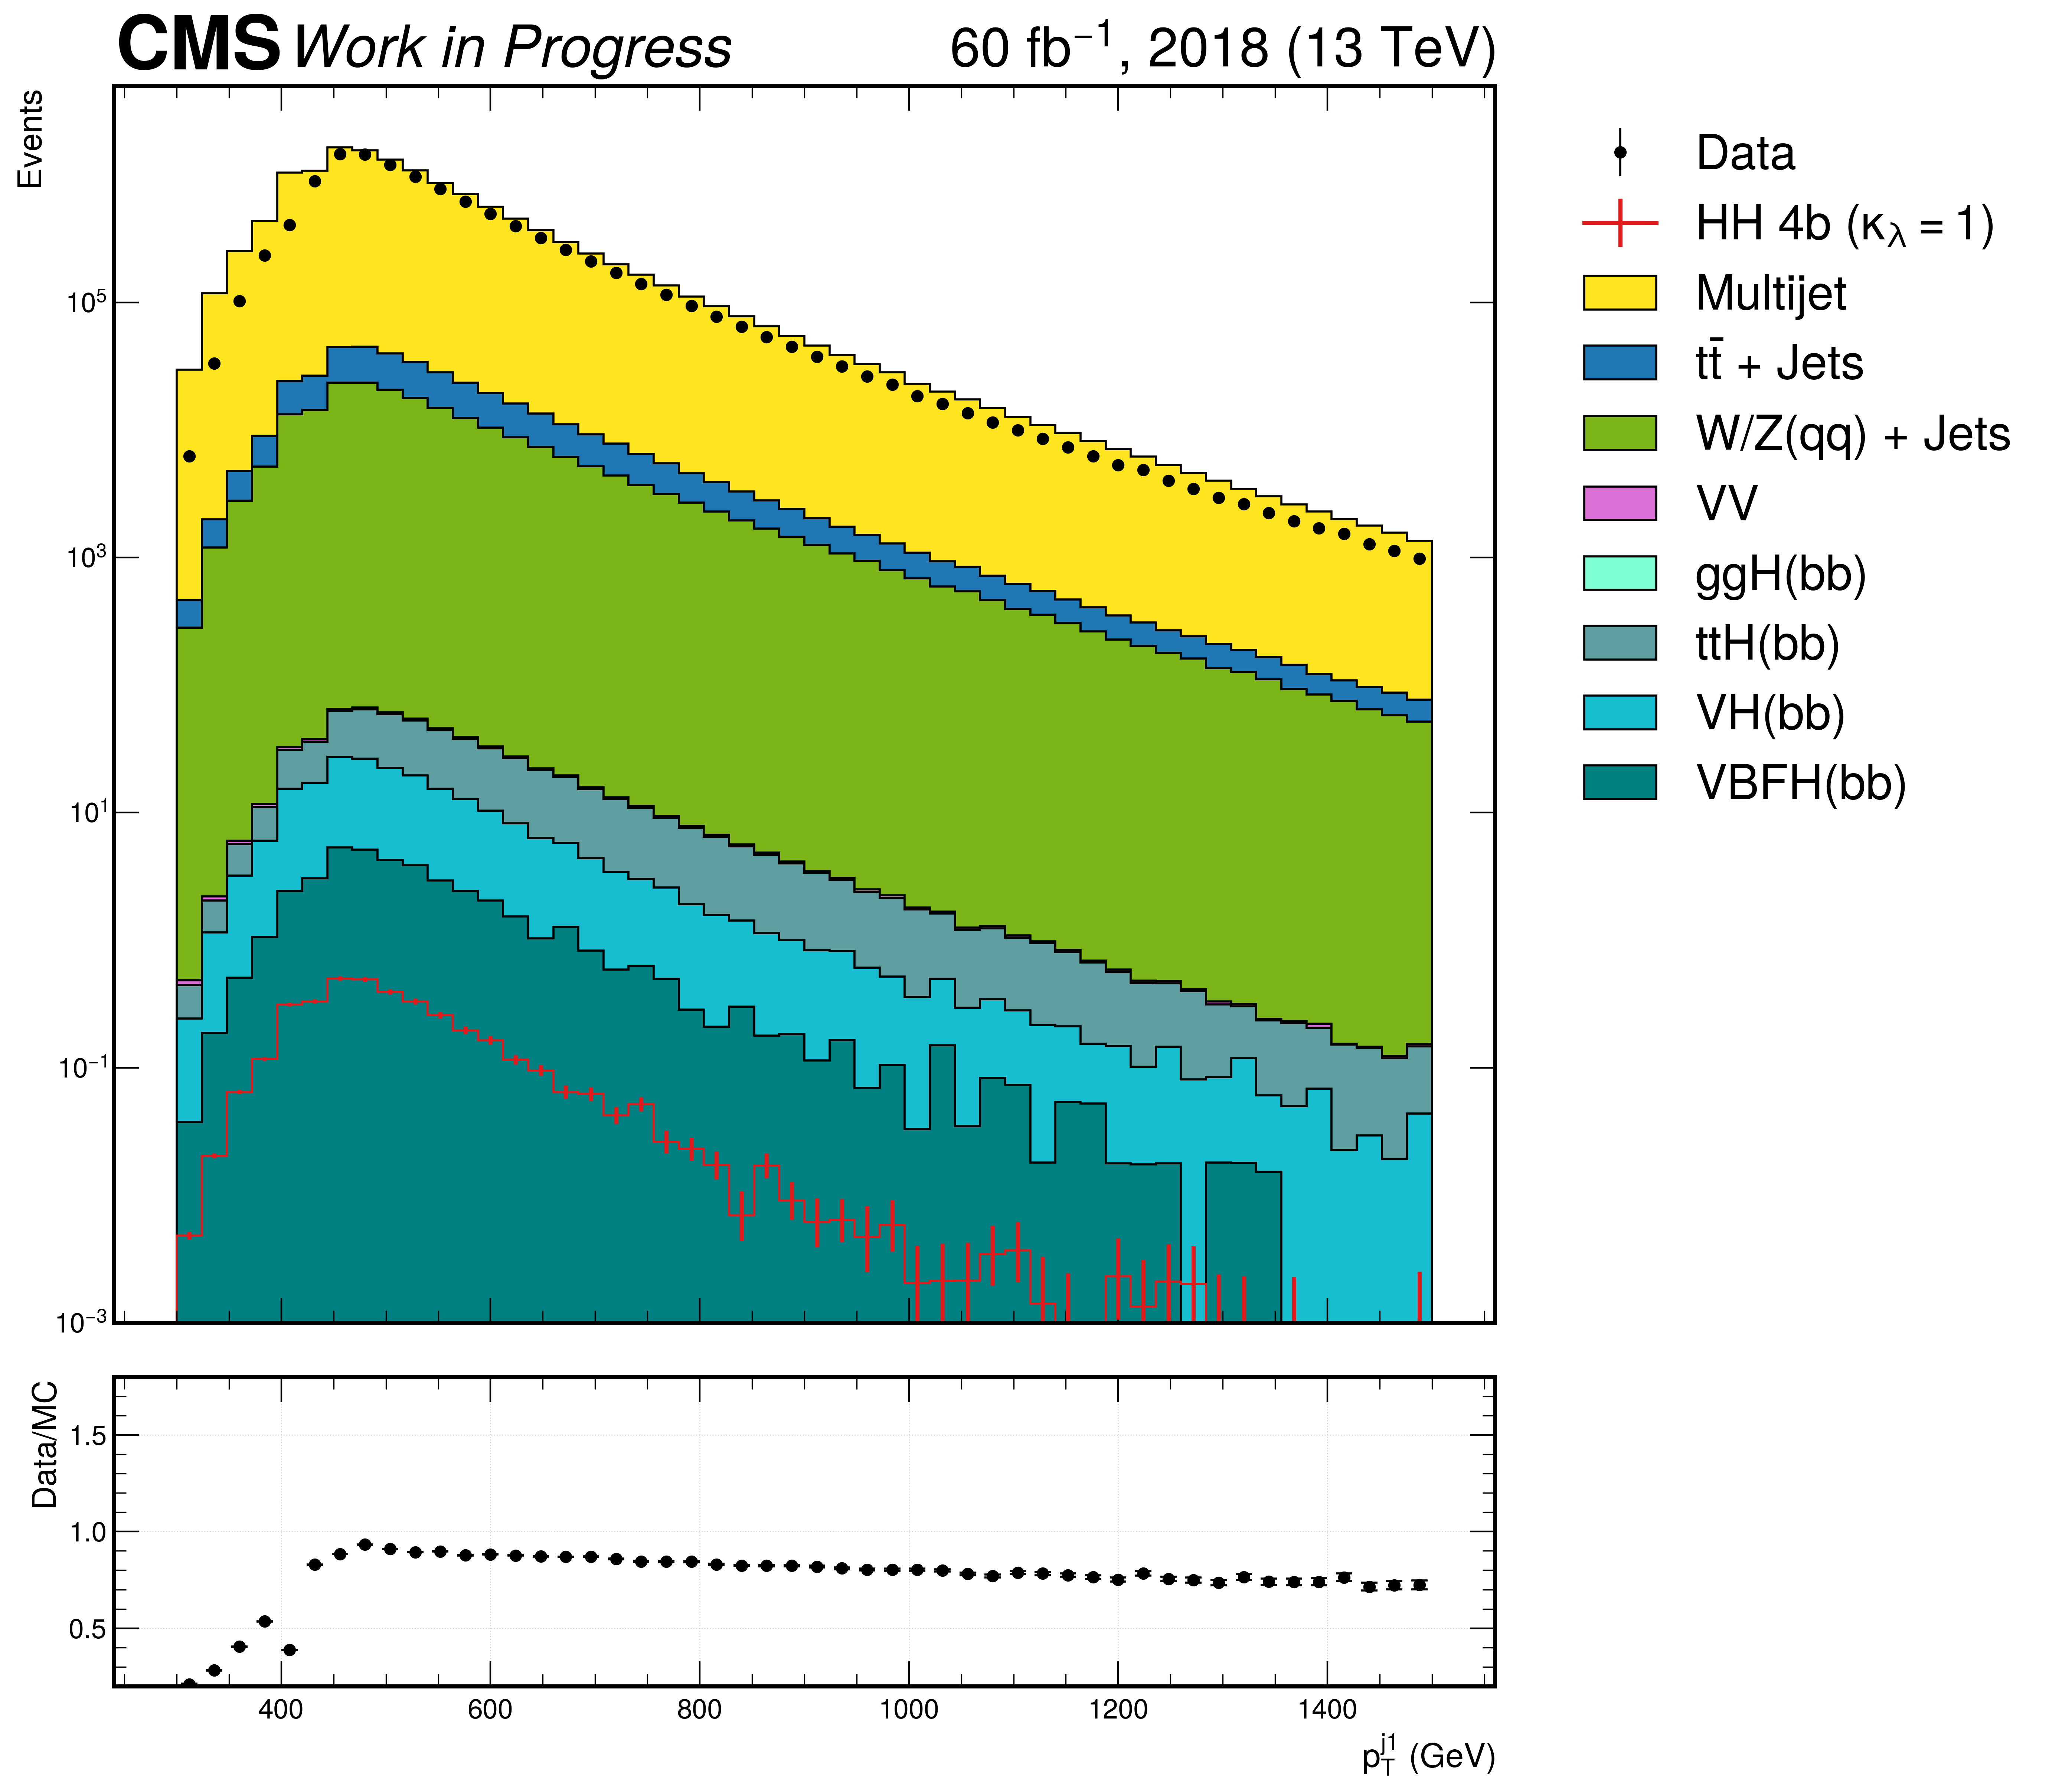

                    ┌────────────────────────────────────────────────────────┐
[-inf,  300) 0      │                                                        │
[ 300,  324) 0.8467 │                                                        │
[ 324,  348) 0.8287 │                                                        │
[ 348,  372) 0.8107 │                                                        │
[ 372,  396) 0.8055 │                                                        │
[ 396,  420) 0.7829 │                                                        │
[ 420,  444) 0.8866 │                                                        │
[ 444,  468) 0.846  │                                                        │
[ 468,  492) 0.8245 │                                                        │
[ 492,  516) 0.8198 │                                                        │
[ 516,  540) 0.8076 │                                                        │
[ 540,  564) 0.8059 │                               

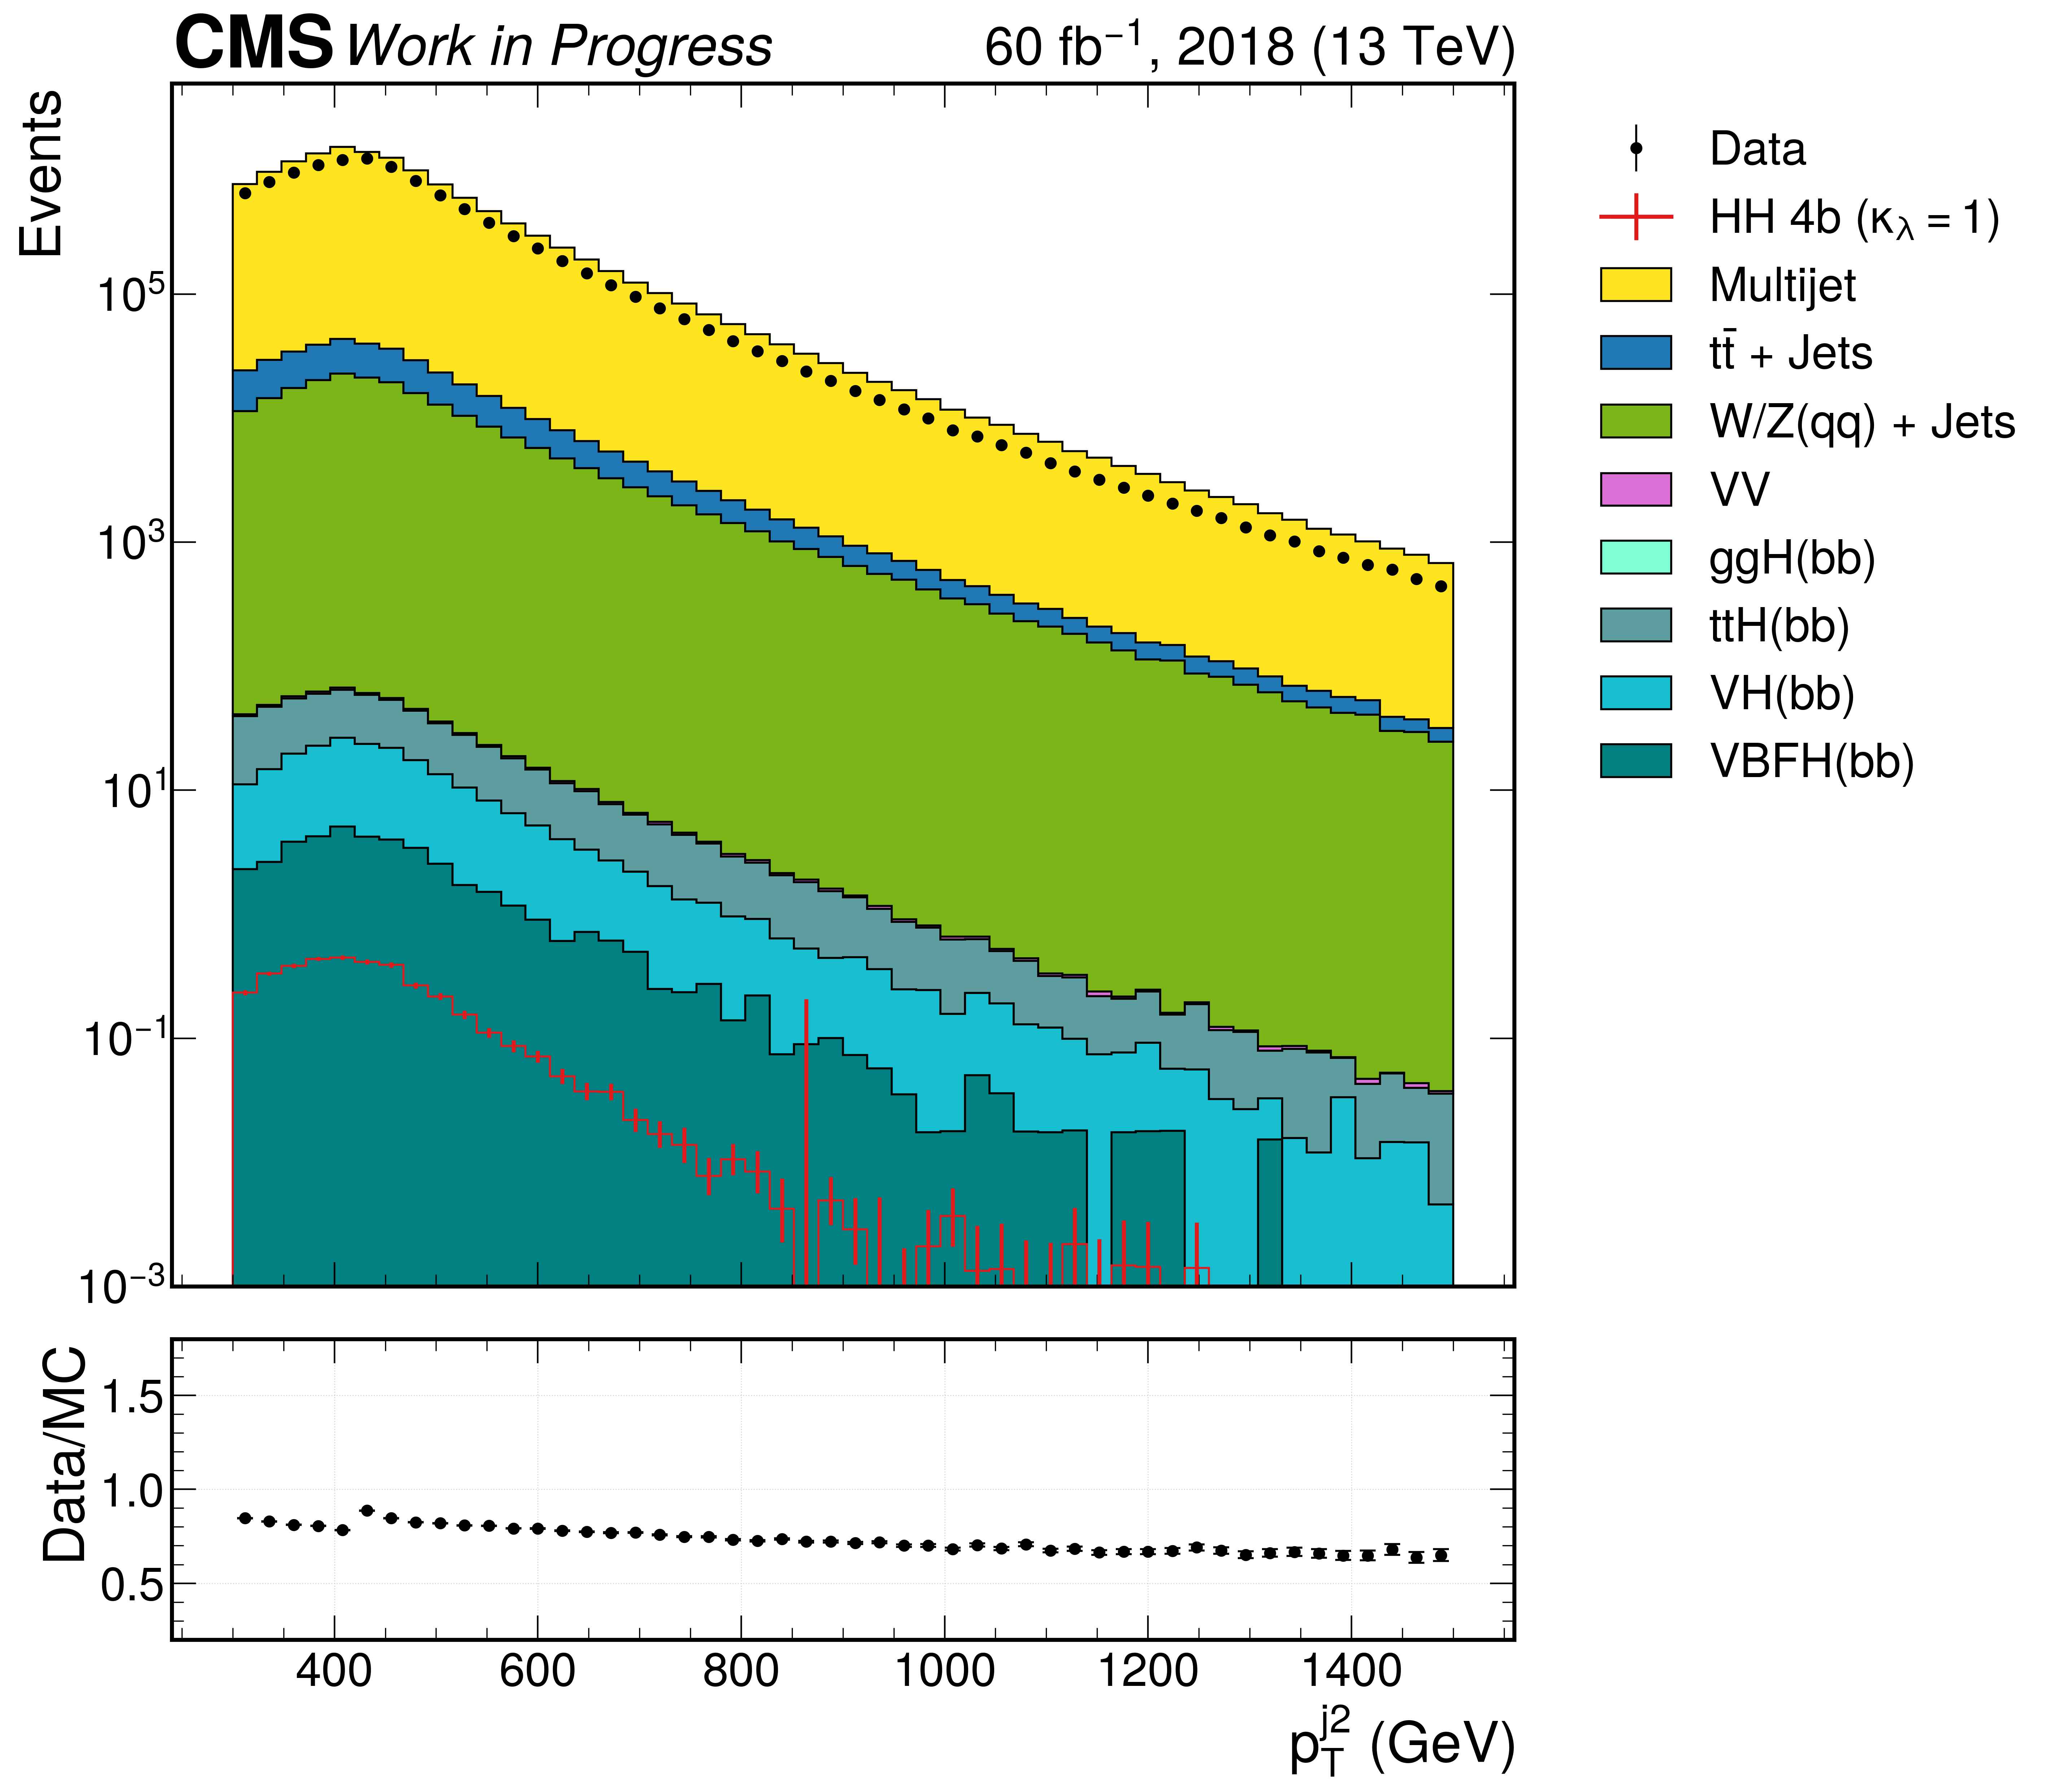

                   ┌─────────────────────────────────────────────────────────┐
[-inf,  60) 295384 │████████████████████████████████████████████████████████ │
[  60,  70) 0.835  │                                                         │
[  70,  80) 0.8189 │                                                         │
[  80,  90) 0.8171 │                                                         │
[  90, 100) 0.8152 │                                                         │
[ 100, 110) 0.8019 │                                                         │
[ 110, 120) 0.7929 │                                                         │
[ 120, 130) 0.7912 │                                                         │
[ 130, 140) 0.7853 │                                                         │
[ 140, 150) 0.7838 │                                                         │
[ 150, 160) 0.7982 │                                                         │
[ 160, 170) 0.8255 │                                

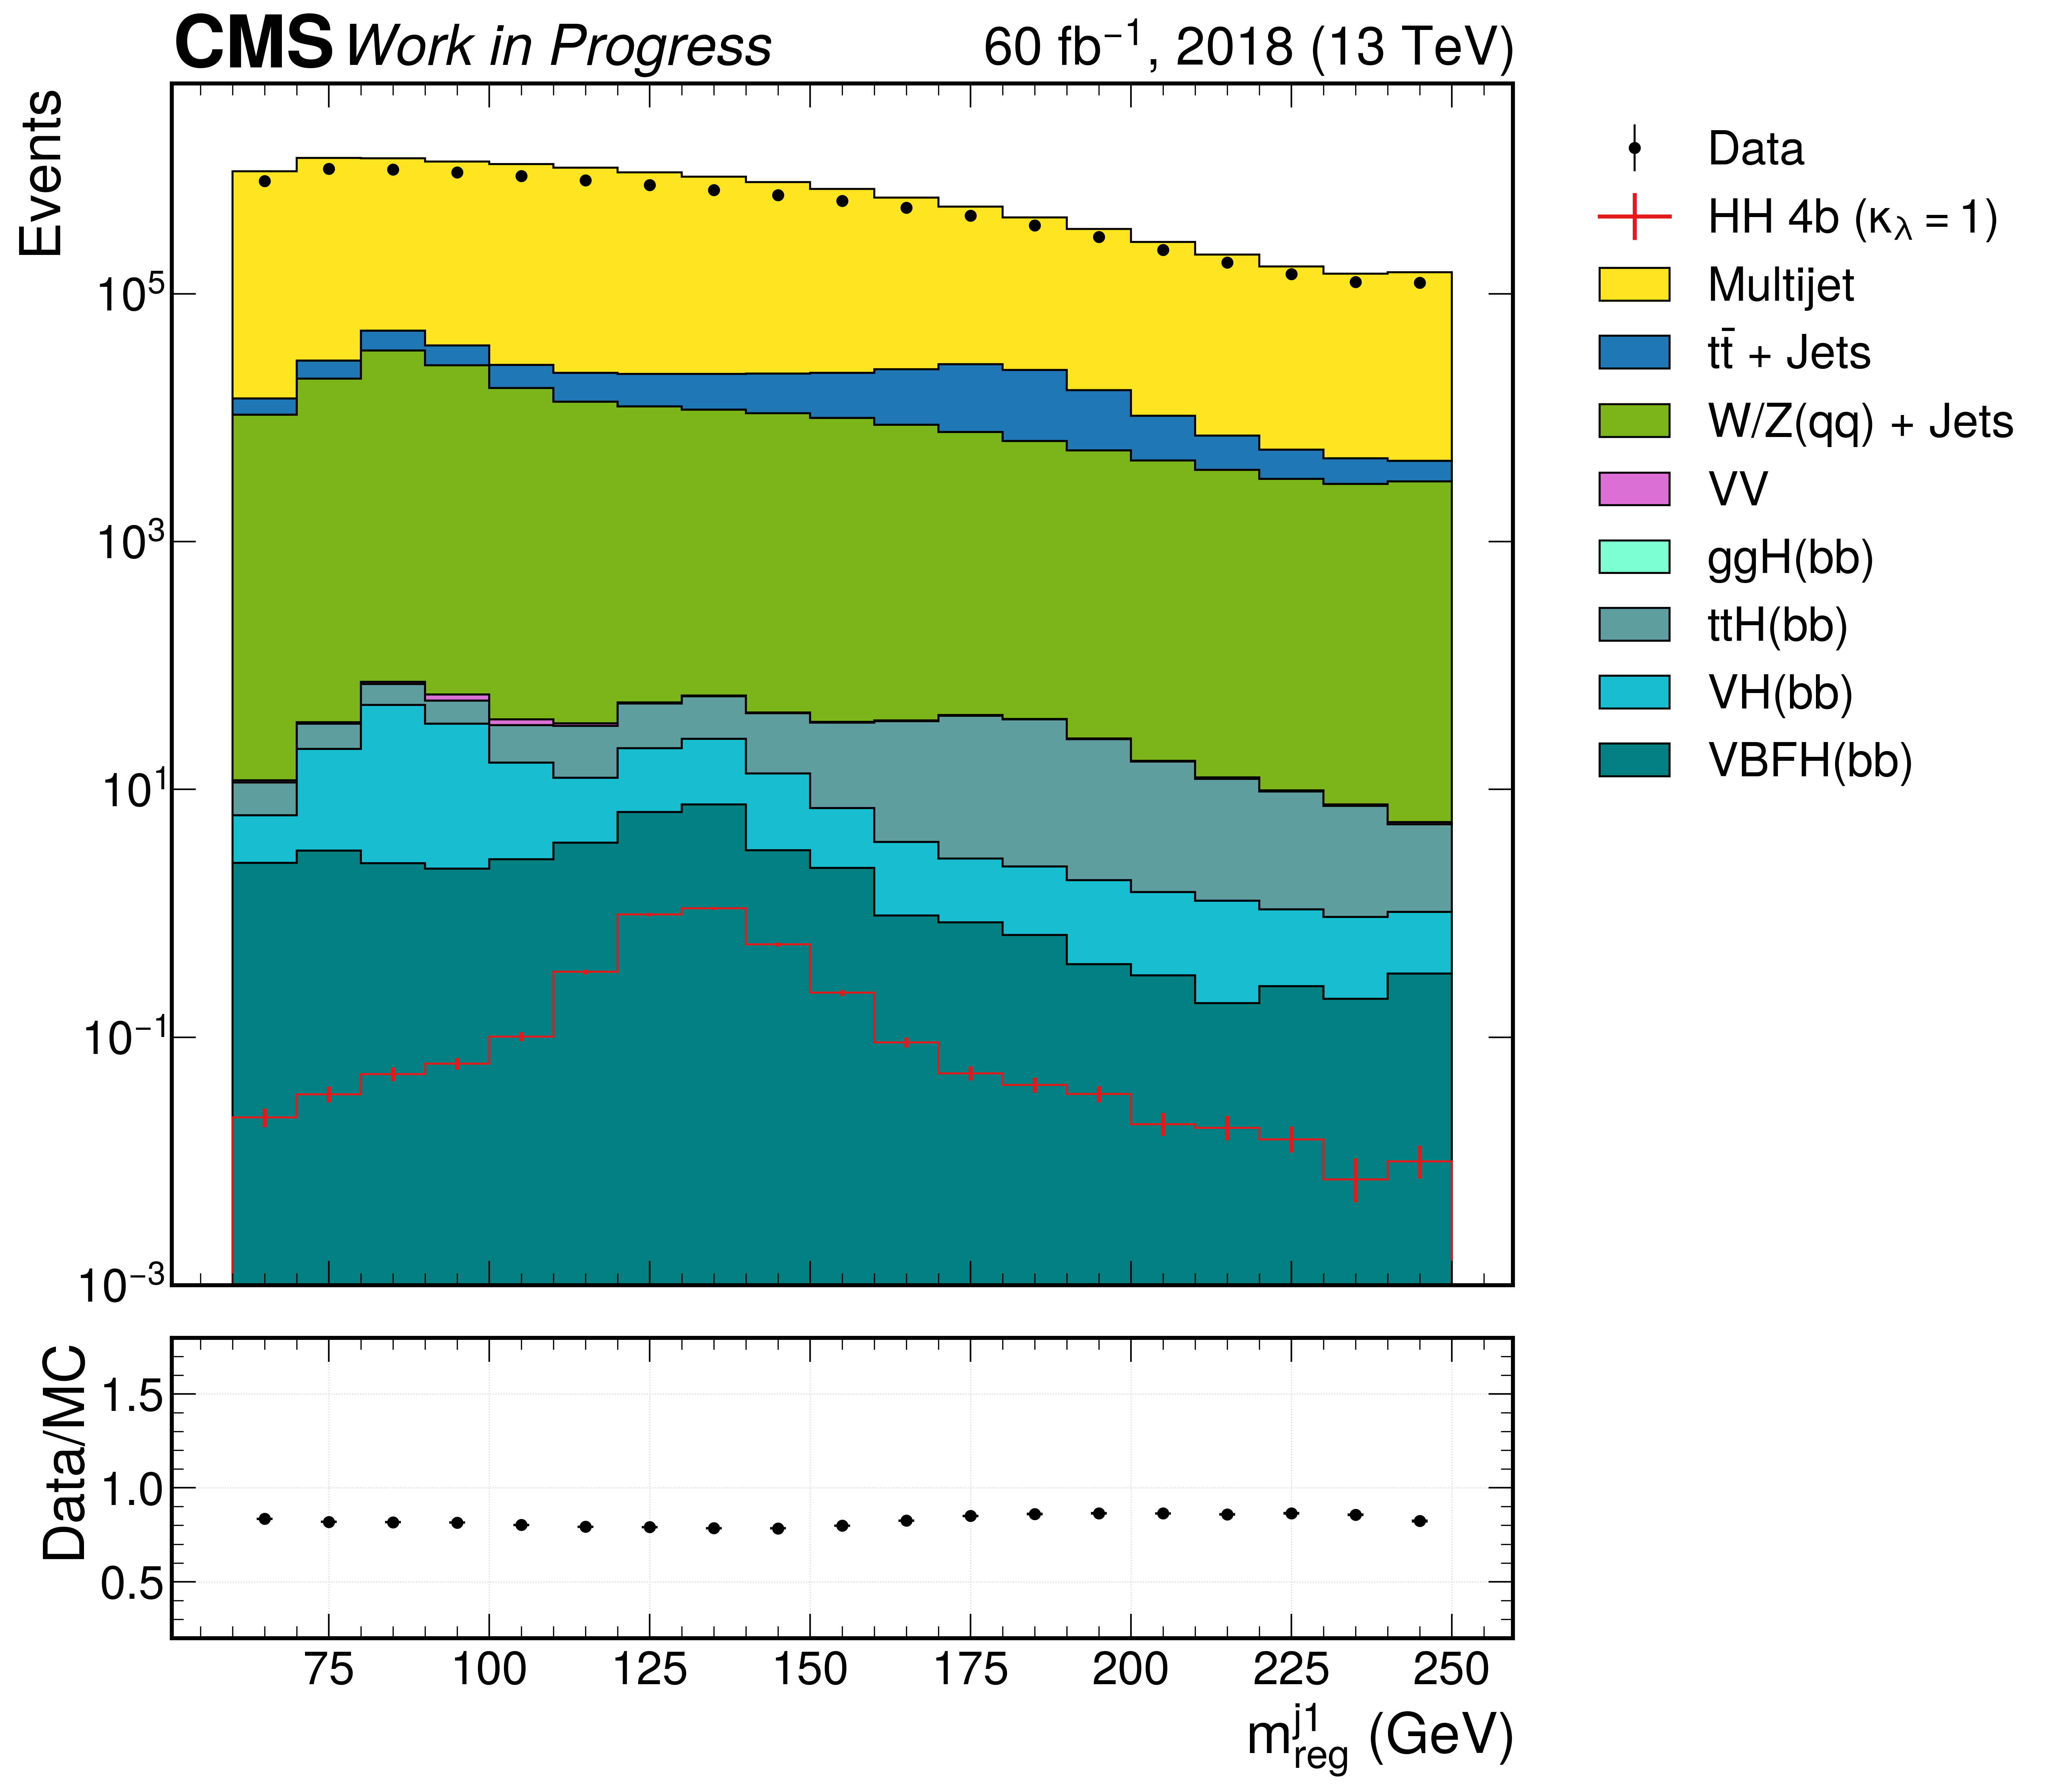

                   ┌─────────────────────────────────────────────────────────┐
[-inf,  60) 306712 │████████████████████████████████████████████████████████ │
[  60,  70) 0.88   │                                                         │
[  70,  80) 0.8314 │                                                         │
[  80,  90) 0.8117 │                                                         │
[  90, 100) 0.7958 │                                                         │
[ 100, 110) 0.7878 │                                                         │
[ 110, 120) 0.7841 │                                                         │
[ 120, 130) 0.7893 │                                                         │
[ 130, 140) 0.7954 │                                                         │
[ 140, 150) 0.8067 │                                                         │
[ 150, 160) 0.8186 │                                                         │
[ 160, 170) 0.8362 │                                

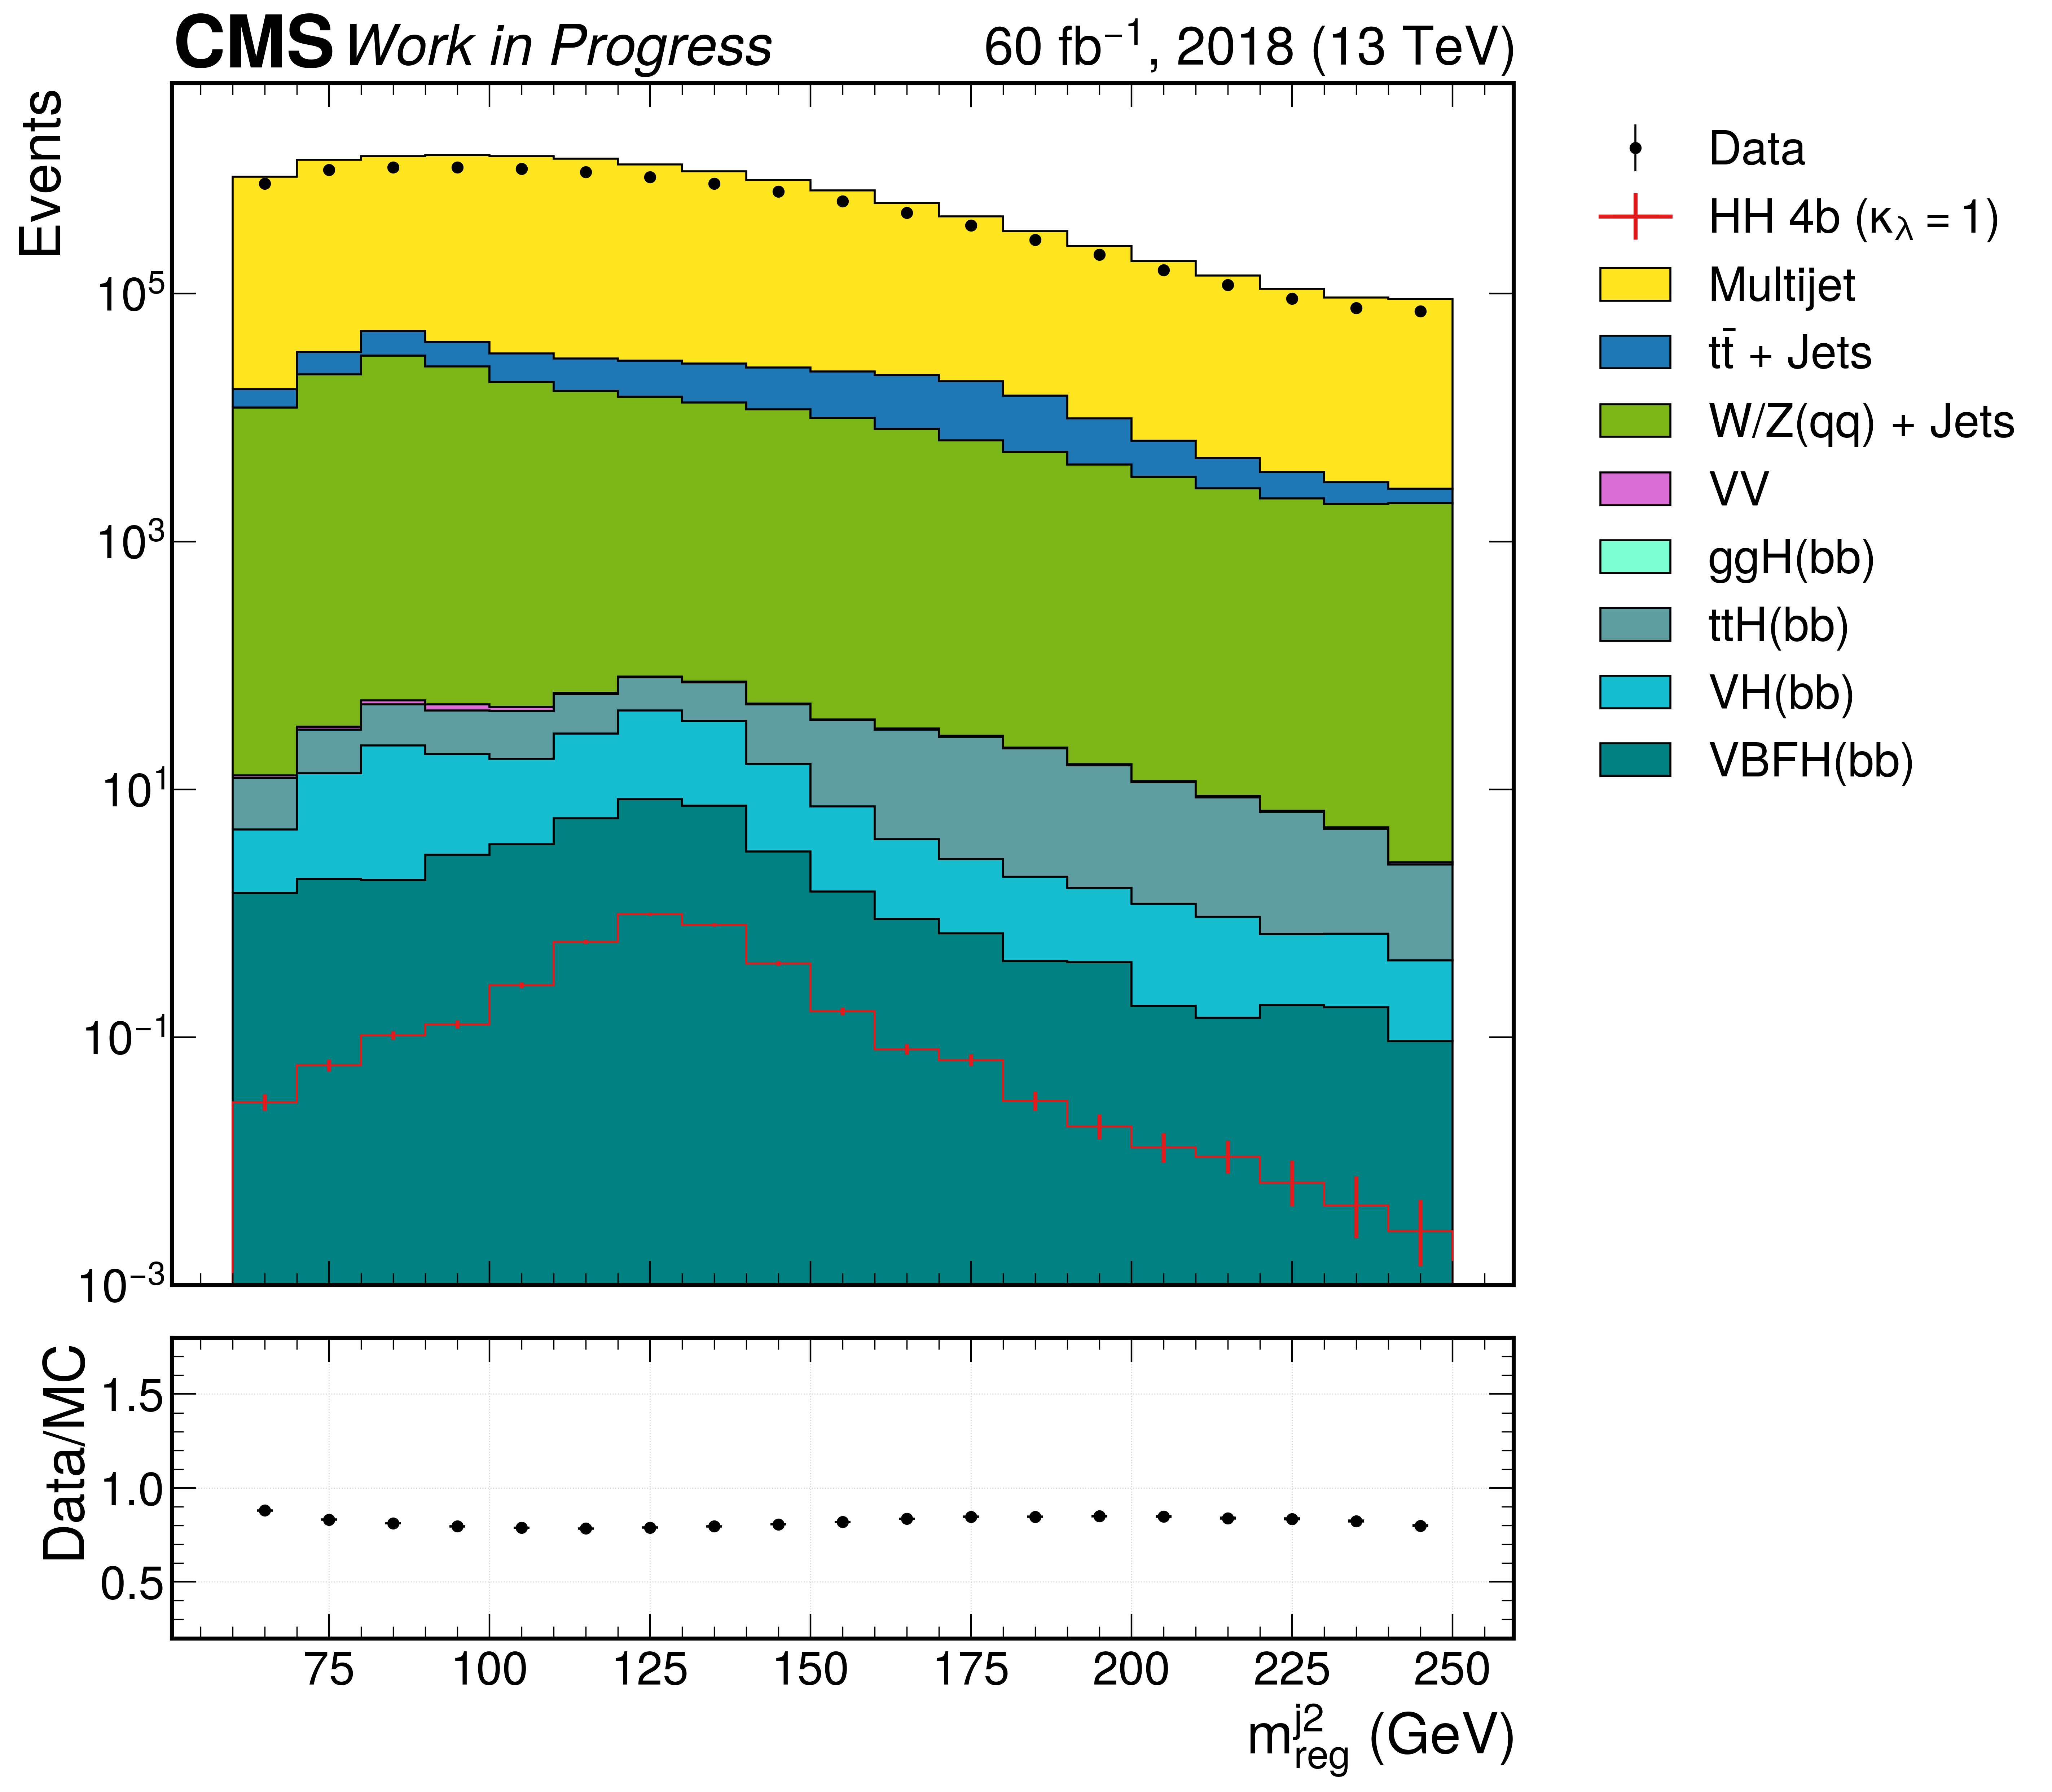

                   ┌─────────────────────────────────────────────────────────┐
[-inf,  60) 0      │                                                         │
[  60,  70) 0.8288 │                                                         │
[  70,  80) 0.8138 │                                                         │
[  80,  90) 0.8106 │                                                         │
[  90, 100) 0.8058 │                                                         │
[ 100, 110) 0.7952 │                                                         │
[ 110, 120) 0.7901 │                                                         │
[ 120, 130) 0.7846 │                                                         │
[ 130, 140) 0.7867 │                                                         │
[ 140, 150) 0.7968 │                                                         │
[ 150, 160) 0.7906 │                                                         │
[ 160, 170) 0.8259 │                                

KeyboardInterrupt: 

In [83]:
ylims = {
    "2018": 5e6,
    "2022": 1e5,
    "2022EE": 4e5,
}

# {var: (bins, label)}
control_plot_vars = [
    # var must match key in events dictionary (i.e. as saved in parquet file)
    # ShapeVar(var="DijetMass", label=r"$m^{jj}$ (GeV)", bins=[30, 600, 4000]),
    ShapeVar(var="ak8FatJetPt0", label=r"$p_T^{j1}$ (GeV)", bins=[50, 300, 1500]),
    ShapeVar(var="ak8FatJetPt1", label=r"$p_T^{j2}$ (GeV)", bins=[50, 300, 1500]),
    ShapeVar(
        var="ak8FatJetPNetMass0",
        label=r"$m_{reg}^{j1}$ (GeV)",
        bins=[19, 60, 250],
        significance_dir="bin",
    ),
    ShapeVar(
        var="ak8FatJetPNetMass1",
        label=r"$m_{reg}^{j2}$ (GeV)",
        bins=[19, 60, 250],
        significance_dir="bin",
    ),
    ShapeVar(
        var="ak8FatJetMsd0",
        label=r"$m_{SD}^{j1}$ (GeV)",
        bins=[19, 60, 250],
        significance_dir="bin",
    ),
    ShapeVar(
        var="ak8FatJetMsd1",
        label=r"$m_{SD}^{j2}$ (GeV)",
        bins=[19, 60, 250],
        significance_dir="bin",
    ),
    # ShapeVar(
    #     var="ak8FatJetPNetXbb0",
    #     label=r"$T_{Xbb}^{j1}$",
    #     bins=[50, 0.0, 1],
    # ),
    # ShapeVar(
    #     var="ak8FatJetPNetXbb1",
    #     label=r"$T_{Xbb}^{j2}$",
    #     bins=[50, 0.0, 1],
    # ),
    # ShapeVar(
    #     var="ht",
    #     label=r"HT (GeV)",
    #     bins=[50, 0, 4000],
    # ),
]

hists = {}
for shape_var in control_plot_vars:
    if shape_var.var not in hists:
        hists[shape_var.var] = utils.singleVarHist(
            events_dict,
            shape_var,
            weight_key="weight",
        )

sig_keys = ["hh4b"]
for shape_var in control_plot_vars:
    name = f"{plot_dir}/{shape_var.var}.pdf"
    plotting.ratioHistPlot(
        hists[shape_var.var],
        year,
        sig_keys,
        bg_keys,
        name=name,
        show=True,
        log=True,
        plot_significance=False,
        significance_dir=shape_var.significance_dir,
        ratio_ylims=[0.2, 1.8],
        ylim=ylims[year],
        energy="13"
    )
    # break

mSD vs mReg

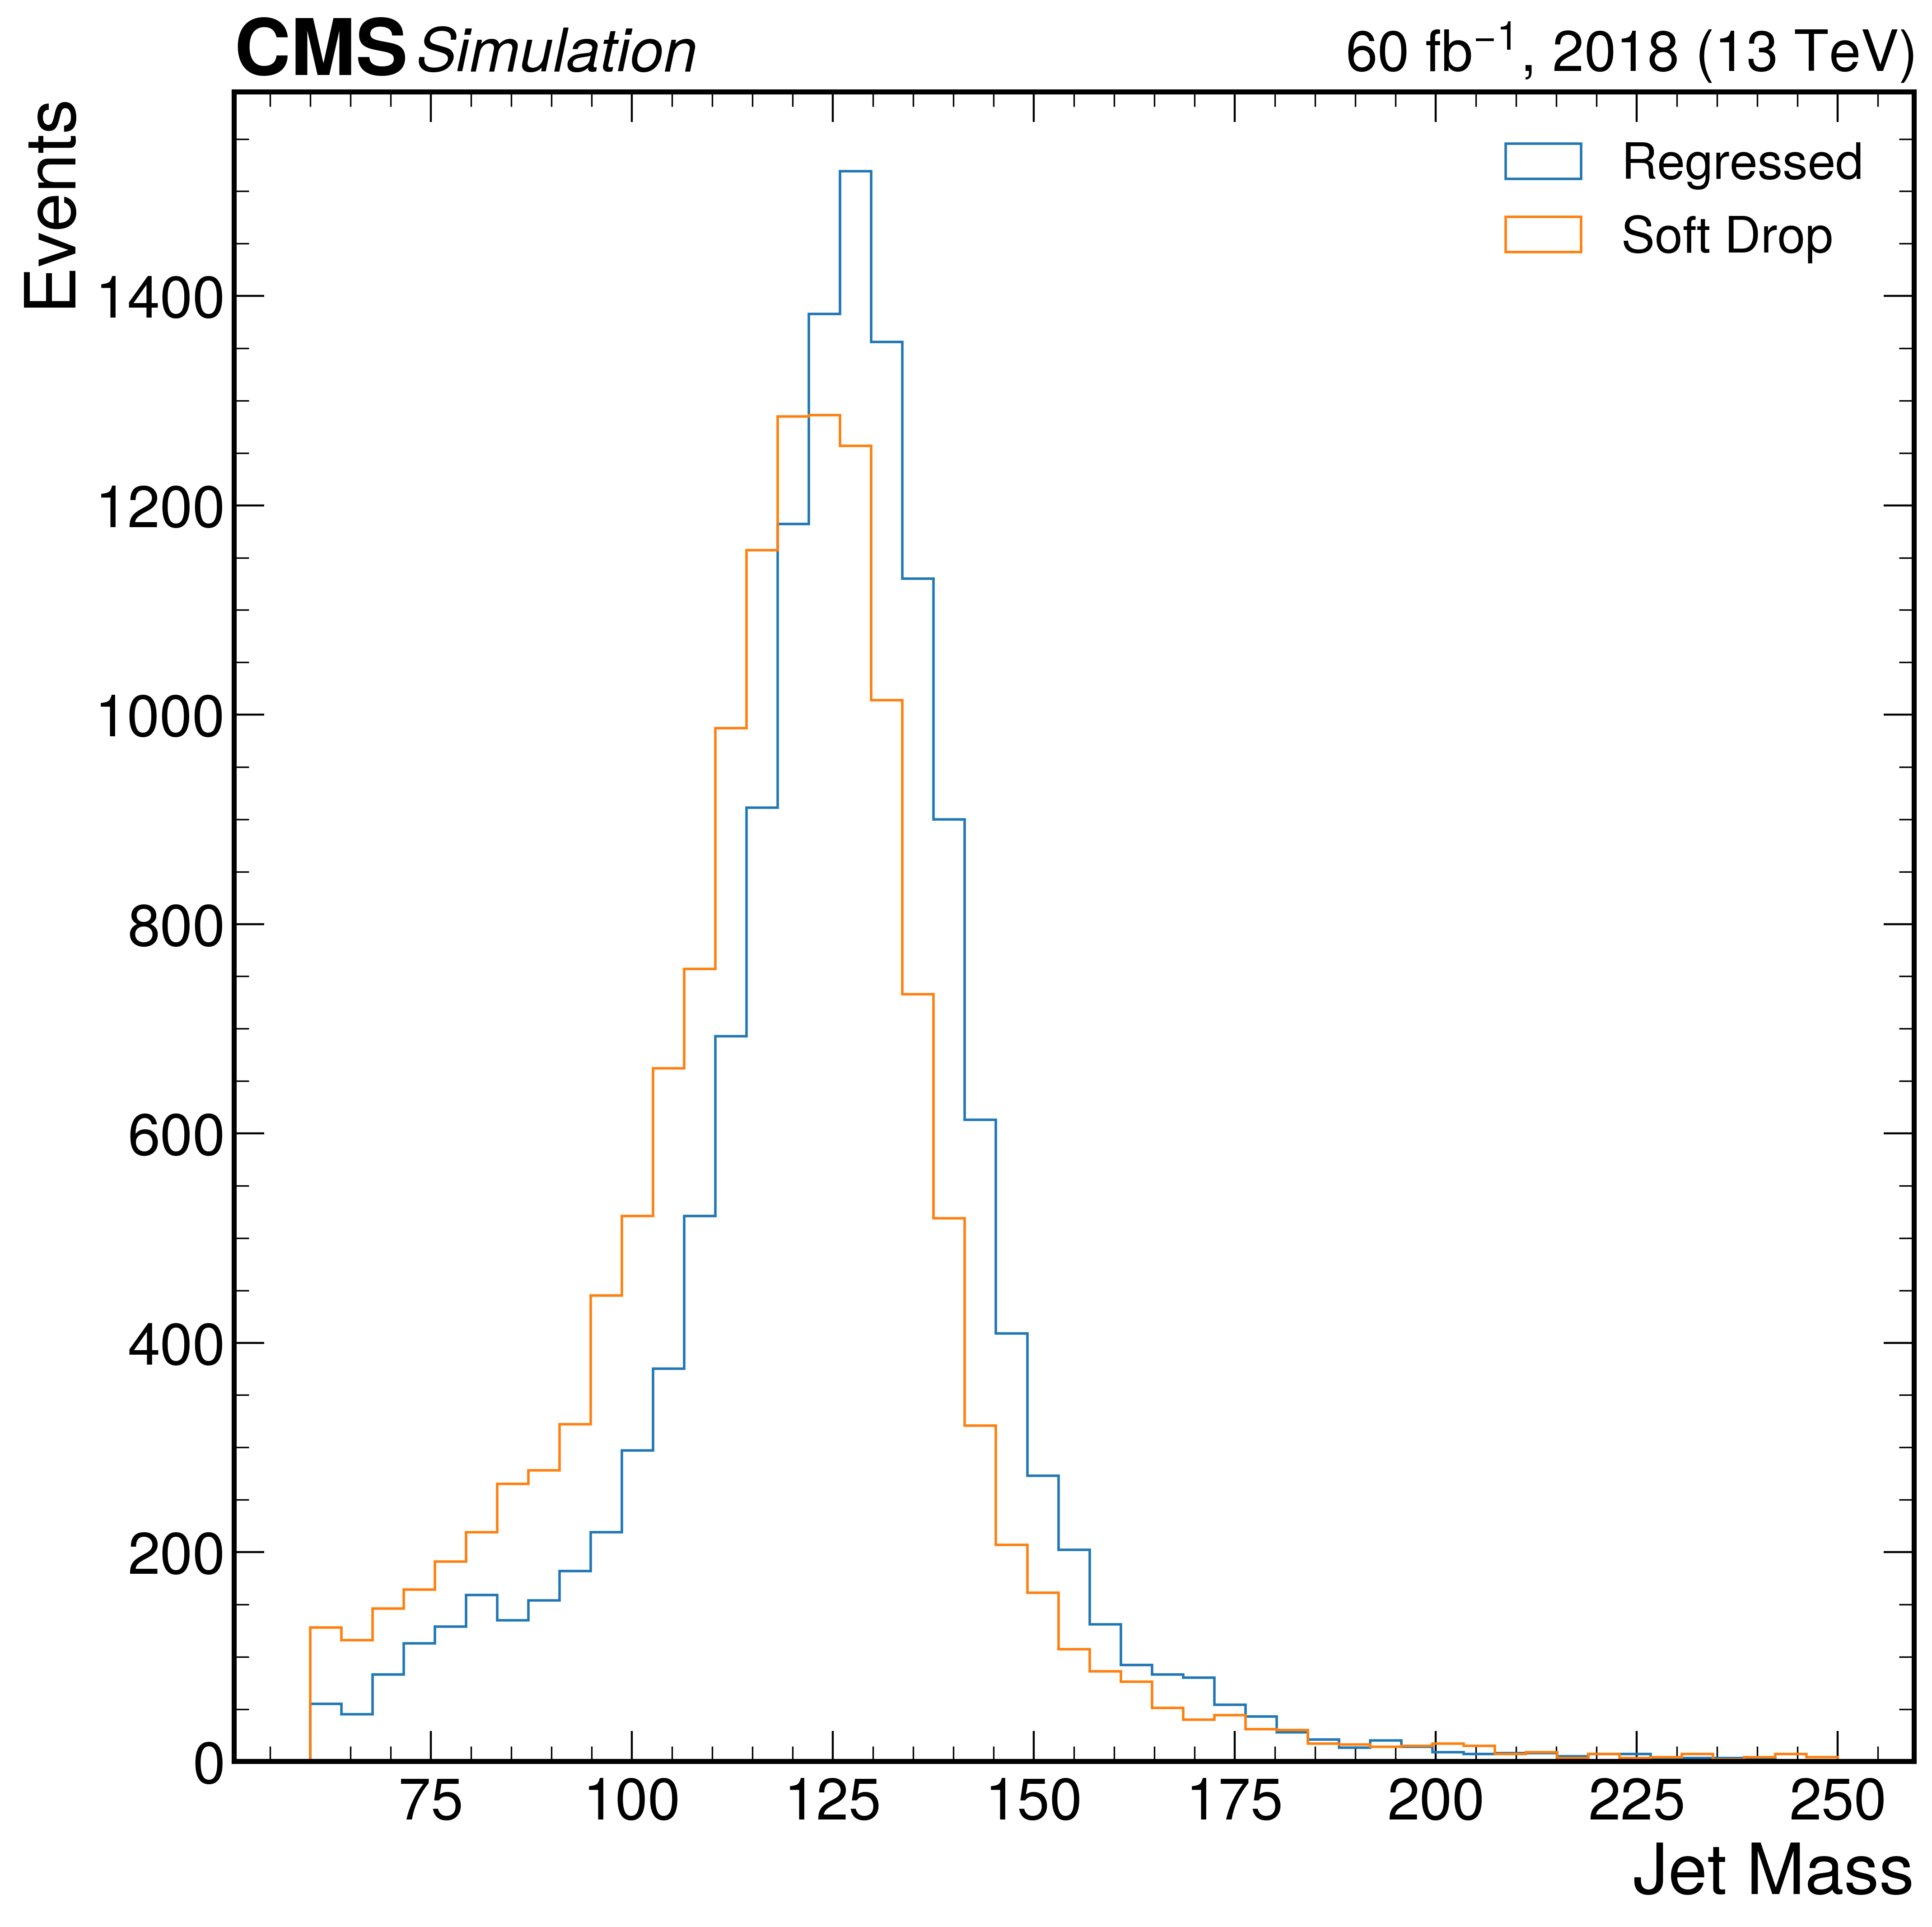

In [ ]:
events = events_dict["hh4b"]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt.rcParams.update({"font.size": 24})

bins = np.linspace(60, 250, 50)

ax.hist(
    events["ak8FatJetPNetMass"][1],
    bins=bins,
    histtype="step",
    label="Regressed",
)

ax.hist(
    events["ak8FatJetMsd"][1],
    bins=bins,
    histtype="step",
    label="Soft Drop",
)

ax.set_xlabel("Jet Mass")
ax.set_ylabel("Events")

hep.cms.label(data=False, year=year, lumi=round(LUMI[year] / 1e3), com="13")

ax.legend()
plt.savefig(f"{plot_dir}/msd_mreg.pdf", bbox_inches="tight")
plt.show()

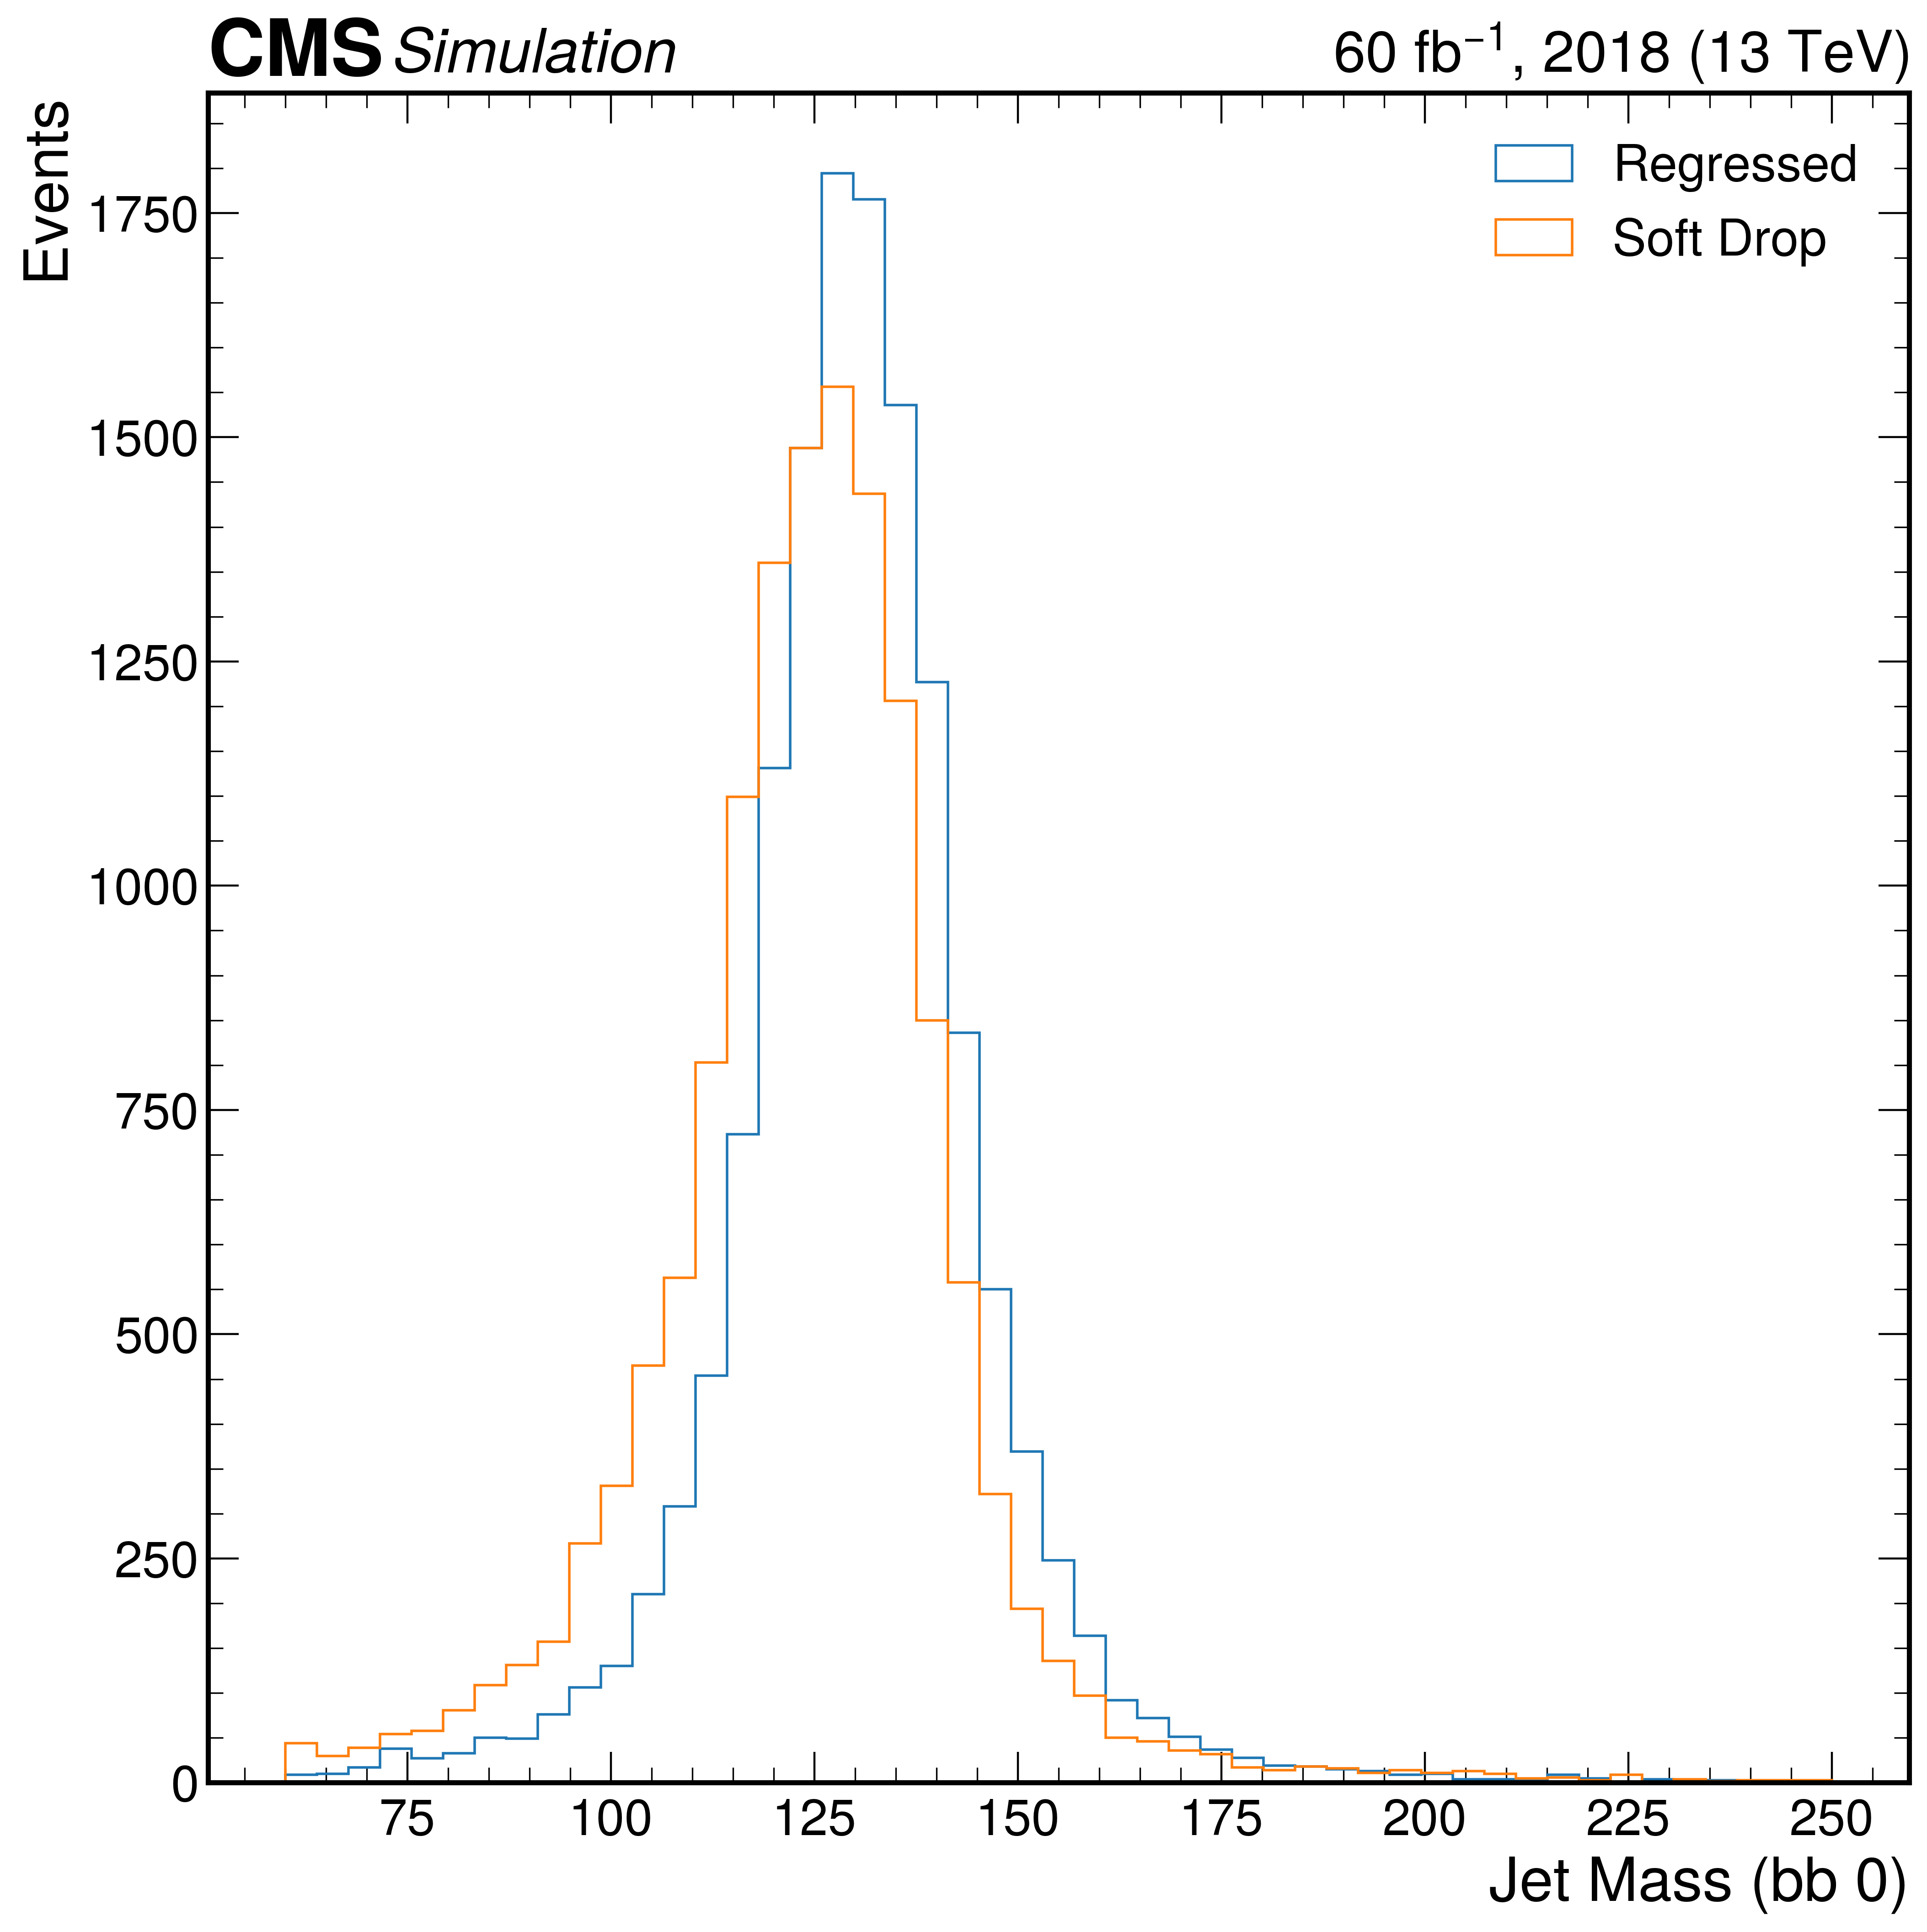

In [ ]:
events = events_dict["hh4b"]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt.rcParams.update({"font.size": 24})

bins = np.linspace(60, 250, 50)

ax.hist(
    utils.get_feat(events, "bb0FatJetPNetMass", bb_masks["hh4b"]),
    bins=bins,
    histtype="step",
    label="Regressed",
)

ax.hist(
    utils.get_feat(events, "bb0FatJetMsd", bb_masks["hh4b"]),
    bins=bins,
    histtype="step",
    label="Soft Drop",
)

ax.set_xlabel("Jet Mass (bb 0)")
ax.set_ylabel("Events")

hep.cms.label(data=False, year=year, lumi=round(LUMI[year] / 1e3), com="13")

ax.legend()
plt.savefig(f"{plot_dir}/msd_mreg_bb0.pdf", bbox_inches="tight")
plt.show()

## ROC Curve

Get true Higgses

In [ ]:
events = events_dict["hh4b"]

indexak8 = events["ak8FatJetHiggsMatchIndex"].to_numpy()
nbh1ak8 = events["ak8FatJetNumBMatchedH1"].to_numpy()
nbh2ak8 = events["ak8FatJetNumBMatchedH2"].to_numpy()

# ak8 jets matched to h1 and h2
h1ak8 = indexak8 == 0
h2ak8 = indexak8 == 1
num_ak8m2h1 = h1ak8.sum(axis=1)
num_ak8m2h2 = h2ak8.sum(axis=1)
h1m1ak8 = num_ak8m2h1 == 1
h2m1ak8 = num_ak8m2h2 == 1

# ak8 jets matched to 2 b-quarks
h1ak8nb2 = (indexak8 == 0) & (nbh1ak8 == 2)
h2ak8nb2 = (indexak8 == 1) & (nbh2ak8 == 2)
h1m1ak8b2 = h1ak8nb2.sum(axis=1) == 1
h2m1ak8b2 = h2ak8nb2.sum(axis=1) == 1
boosted_nb2 = h1m1ak8b2 & h2m1ak8b2

# fatjet matched to H1
fj_mwh1_idx = events["ak8FatJetHiggsMatchIndex"].to_numpy() == 0
fj_score = events["ak8FatJetPNetXbb"].to_numpy()
sig_jets_score = fj_score[boosted_nb2][fj_mwh1_idx[boosted_nb2]]
sig_jets_score.shape

sig_jets_score = fj_score[fj_mwh1_idx]
sig_jets_score.shape

(13281,)

In [ ]:
bg_jets_score = events_dict["qcd"]["ak8FatJetPNetXbb"].values.reshape(-1)[2:]
bg_jets_score.shape

(10568840,)

In [ ]:
from sklearn.metrics import roc_curve

bg_skip = 4
sig_key = "hh4b"
bg_keys = ["qcd"] 

y_true = np.concatenate(
    [
        np.ones(len(sig_jets_score)),
        np.zeros(len(bg_jets_score) // bg_skip),
    ]
)

scores = np.concatenate((sig_jets_score, bg_jets_score[::bg_skip]))

fpr, tpr, thresholds = roc_curve(y_true, scores)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

plot_thresholds = [0.35, 0.8, 0.95, 0.975, 0.985, 0.99]
th_colours = ["#9381FF", "#1f78b4", "#a6cee3", "#ff7f00", "#7CB518", "#EDB458", "#36213E"]

pths = {th: [[], []] for th in plot_thresholds}
plt.figure(figsize=(12, 12))
plt.plot(
    tpr,
    fpr,
    linewidth=2,
)

for th in plot_thresholds:
    idx = find_nearest(thresholds, th)
    pths[th][0].append(tpr[idx])
    pths[th][1].append(fpr[idx])


for k, th in enumerate(plot_thresholds):
    plt.scatter(
        *pths[th],
        marker="o",
        s=40,
        label=rf"$T_{{Xbb}}$ > {th}",
        color=th_colours[k],
        zorder=100,
    )

    plt.vlines(
        x=pths[th][0],
        ymin=0,
        ymax=pths[th][1],
        color=th_colours[k],
        linestyles="dashed",
        alpha=0.5,
    )

    plt.hlines(
        y=pths[th][1],
        xmin=0,
        xmax=pths[th][0],
        color=th_colours[k],
        linestyles="dashed",
        alpha=0.5,
    )


hep.cms.label(data=False, year=year, com="13.6")
# plt.hlines(y=0.01, xmin=0, xmax=1, colors="lightgrey", linestyles="dashed")
plt.yscale("log")
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
# plt.suptitle(f"HVV FatJet {pvars['title']} ROC", y=0.95)
# plt.title(cut_labels[cutstr], fontsize=20)
plt.xlim([0, 1])
plt.ylim([1e-3, 1])
plt.legend(loc="upper left")
plt.savefig(f"{plot_dir}/roccurve.pdf", bbox_inches="tight")
plt.close()

### Cut-based selection

In [84]:
# {label: {cutvar: [min, max], ...}, ...}
# https://indico.cern.ch/event/959381/contributions/4041887/attachments/2114263/3556855/20201002_HHTo4B_Summary_B2GDiBosonMeeting.pdf slide 7

selection_regions = {
    "pass": Region(
        cuts={
            "bb0FatJetPNetXbb": [0.985, 1],
            "bb1FatJetPNetXbb": [0.985, 1],
            "bb0FatJetPt": [350, CUT_MAX_VAL],
            "bb1FatJetPt": [310, CUT_MAX_VAL],
            "bb0FatJetPNetMass": [105, 135],
            # "bb1FatJetPNetMass": [95, 135],
        },
        label="Pass",
    ),
    "fail": Region(
        cuts={
            "bb0FatJetPNetXbb": [-CUT_MAX_VAL, 0.985],
            "bb1FatJetPNetXbb": [-CUT_MAX_VAL, 0.985],
            "bb0FatJetPt": [350, CUT_MAX_VAL],
            "bb1FatJetPt": [310, CUT_MAX_VAL],
            "bb0FatJetPNetMass": [105, 135],
        },
        label="Fail",
    ),
}

fit_shape_var = ShapeVar(
    "bb1FatJetPNetMass",
    r"$m^{2}_\mathrm{Reg}$ (GeV)",
    #[19, 60, 250],
    [17, 60, 230],
    reg=True,
    blind_window=[100, 150],
)

pass
                   ┌─────────────────────────────────────────────────────────┐
[-inf,  60) 1      │████▊                                                    │
[  60,  70) 10.13  │███████████████████████████████████████████████▊         │
[  70,  80) 1.038  │████▉                                                    │
[  80,  90) 0.3312 │█▋                                                       │
[  90, 100) 1.29   │██████▏                                                  │
[ 100, 110) 0      │                                                         │
[ 110, 120) 0      │                                                         │
[ 120, 130) 0      │                                                         │
[ 130, 140) 0      │                                                         │
[ 140, 150) 0      │                                                         │
[ 150, 160) 0.8776 │████▏                                                    │
[ 160, 170) 0.8571 │████                       

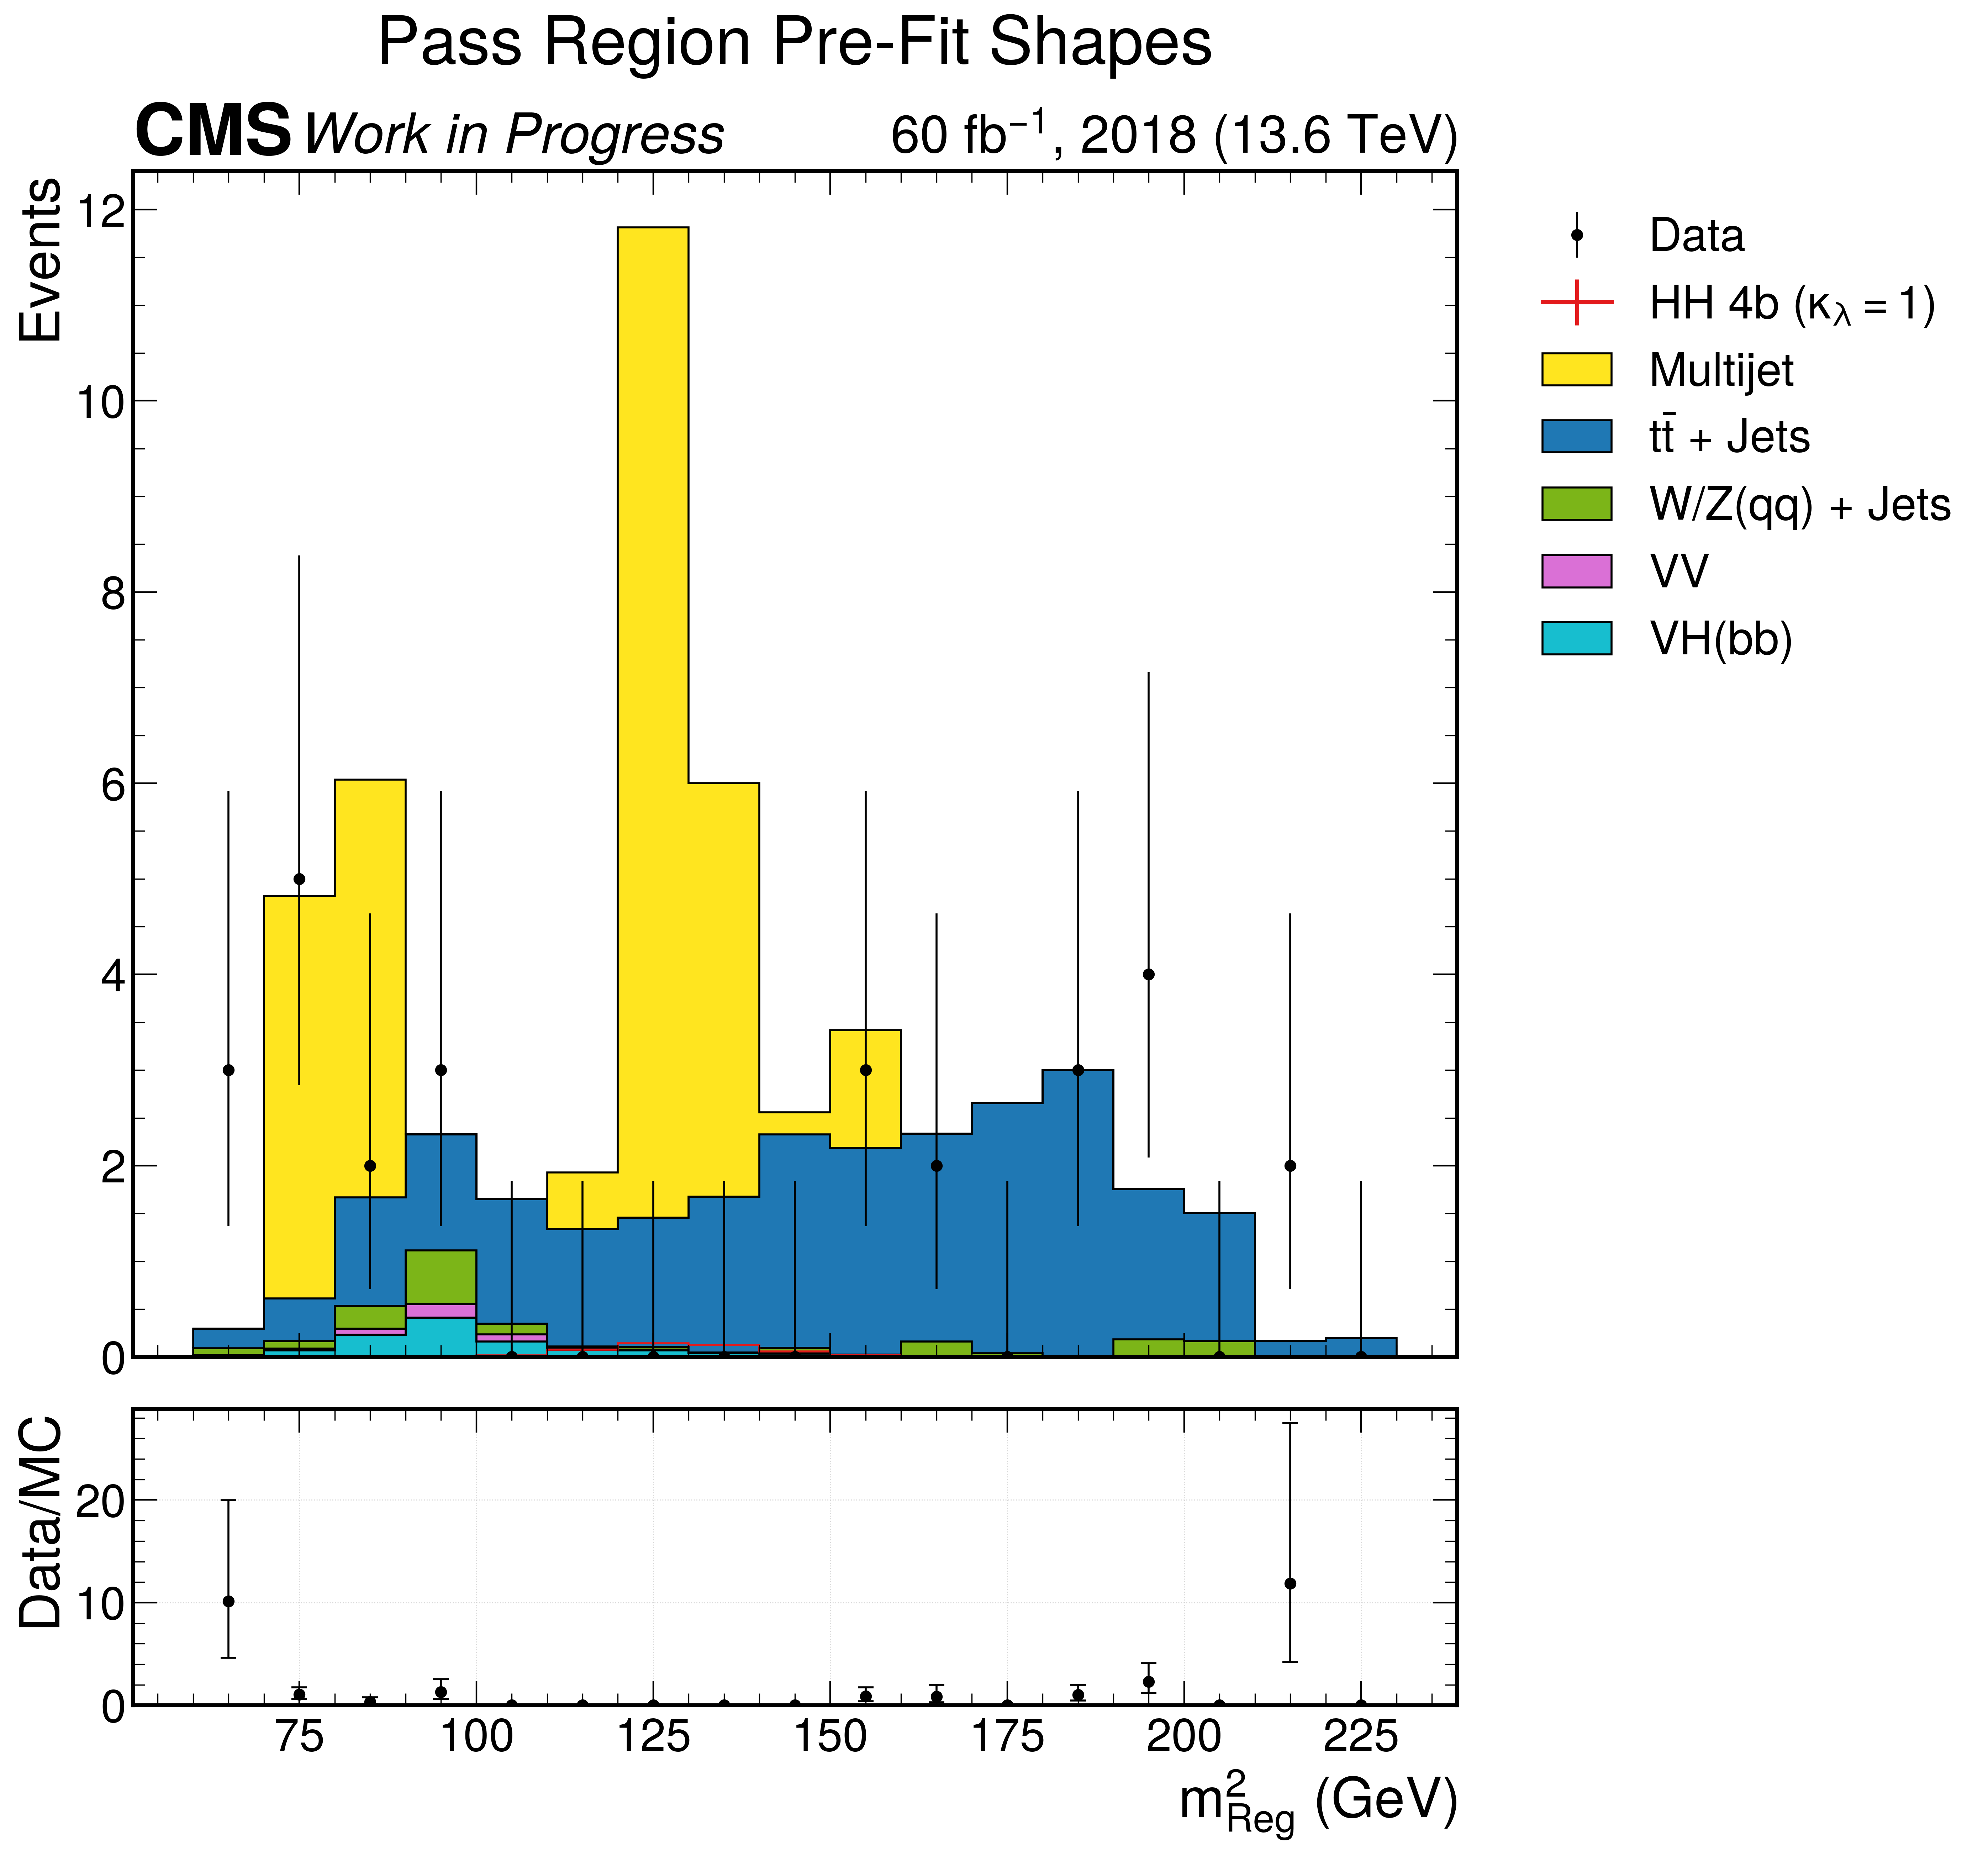

fail
                   ┌─────────────────────────────────────────────────────────┐
[-inf,  60) 66683  │████████████████████████████████████████████████████████ │
[  60,  70) 0.8467 │                                                         │
[  70,  80) 0.8023 │                                                         │
[  80,  90) 0.7885 │                                                         │
[  90, 100) 0.7679 │                                                         │
[ 100, 110) 0.7587 │                                                         │
[ 110, 120) 0.7412 │                                                         │
[ 120, 130) 0.7529 │                                                         │
[ 130, 140) 0.7543 │                                                         │
[ 140, 150) 0.7574 │                                                         │
[ 150, 160) 0.7586 │                                                         │
[ 160, 170) 0.7955 │                           

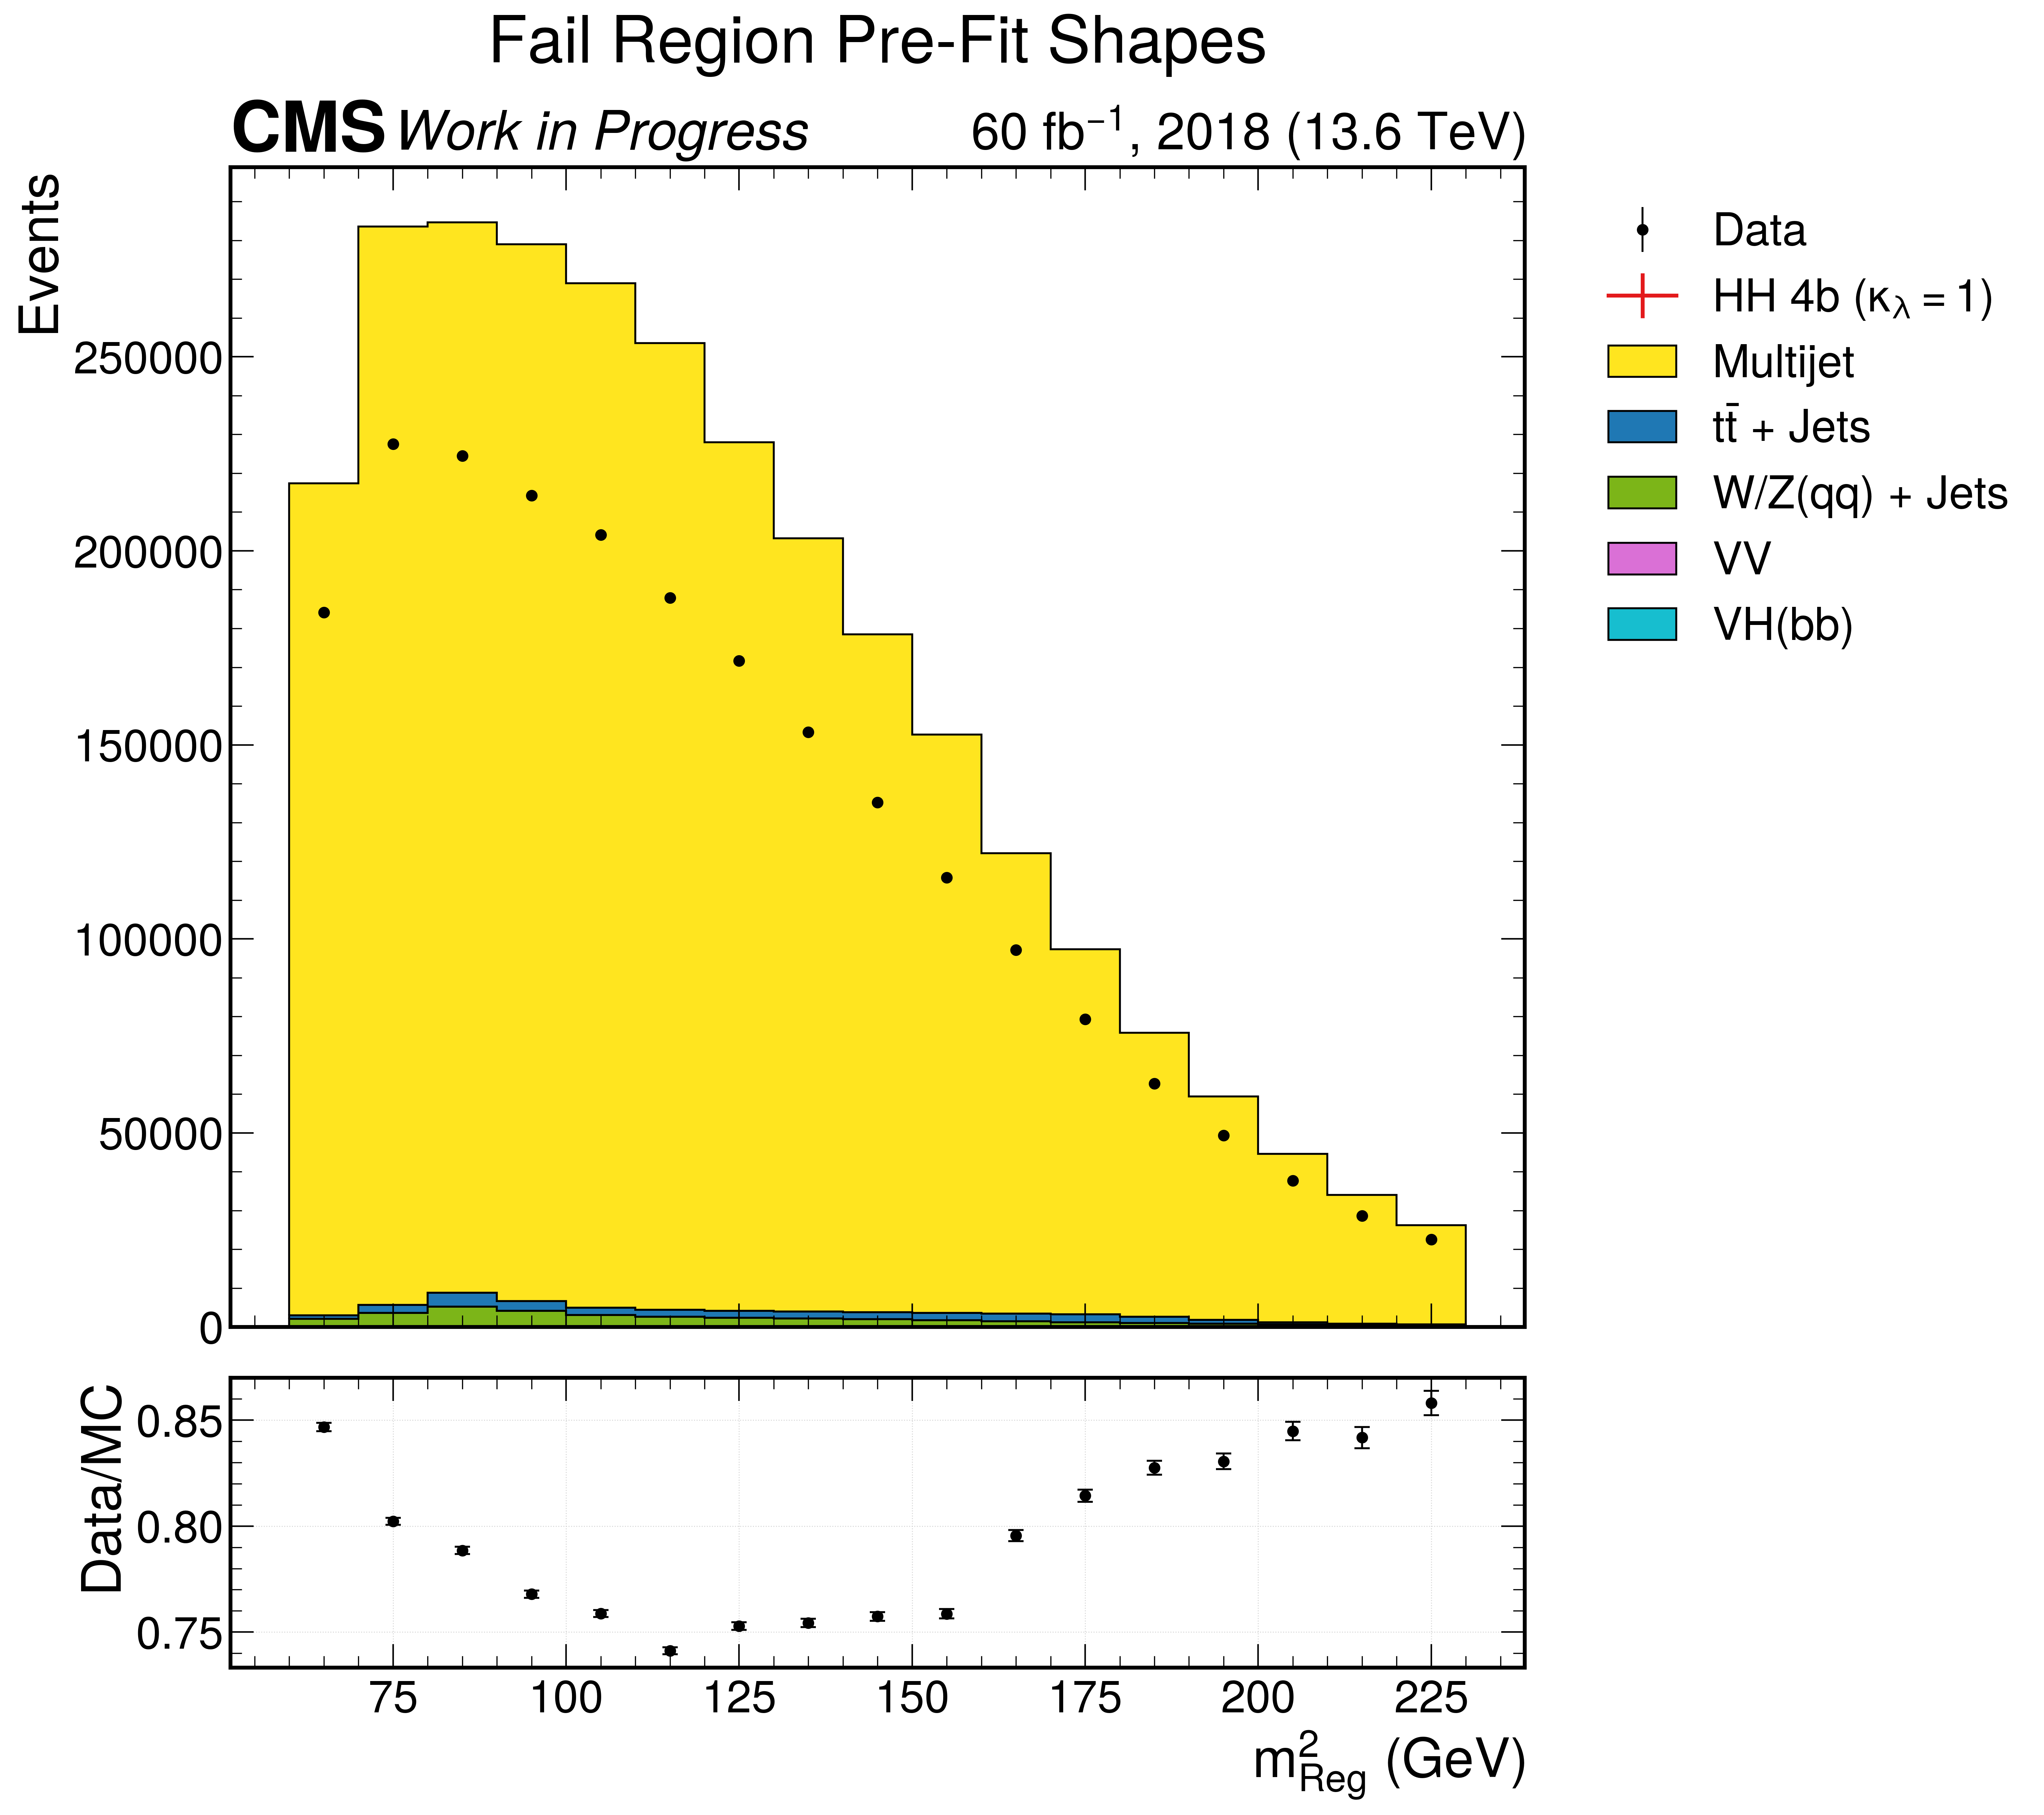

In [85]:
templates = postprocessing.get_templates(
    events_dict,
    bb_masks,
    year,
    sig_keys,
    selection_regions,
    [fit_shape_var],
    {},
    template_dir,
    ["qcd", "ttbar", "vjets", "diboson", "vhtobb"],
    plot_dir,
    cutflow,
    weight_key="weight",
    # weight_shifts=weight_shifts,
    show=True,
)

In [ ]:
p = pd.read_csv(f"{template_dir}/cutflows/{year}/pass_cutflow.csv")
p

Unnamed: 0  Preselection  0.985 ≤ bb0FatJetPNetXbb < 1  \
0       hh4b  3.774126e+00                      2.636743   
1        qcd  1.287102e+07                  72533.146873   
2       data  1.083465e+07                  82307.000000   
3      ttbar  1.851479e+05                   9810.943863   
4      vjets  2.179795e+05                   4265.269629   
5    diboson  2.205277e+01                     11.743943   
6    gghtobb  2.004560e-04                      0.000092   
7   vbfhtobb  4.192265e+01                     23.160623   
8     vhtobb  1.828203e+02                     82.581872   
9    tthtobb  3.840251e+02                     65.028227   

   0.985 ≤ bb1FatJetPNetXbb < 1  bb0FatJetPt >= 350  bb1FatJetPt >= 310  \
0                  7.860861e-01        7.325796e-01        7.291459e-01   
1                  1.112769e+02        1.039136e+02        1.009156e+02   
2                  2.610000e+02        2.470000e+02        2.450000e+02   
3                  1.480369e+02        1.388017e+02        1.371684e+02   
4                  1.015054e+01        9.732192e+00        9.478159e+00   
5                  2.384691e+00        2.217959e+00        2.189745e+00   
6                  2.185392e-07        2.185392e-07        2.118577e-07   
7                  1.571916e-02        1.571916e-02        1.571916e-02   
8                  3.292250e+00        3.117525e+00        3.094008e+00   
9                  1.784936e+00        1.645198e+00        1.629291e+00   

   105 ≤ bb0FatJetPNetMass < 135  
0                   4.547222e-01  
1                   2.593056e+01  
2                   4.800000e+01  
3                   2.405301e+01  
4                   1.757176e+00  
5                   3.550967e-01  
6                   6.981834e-08  
7                   1.571916e-02  
8                   1.139109e+00  
9                   6.503660e-01

In [ ]:
1.17/30

0.039

In [ ]:
0.31/14

0.02214285714285714

In [ ]:
templates

{'pass': Hist(
   StrCategory(['hh4b', 'qcd', 'data', 'ttbar', 'vjets', 'diboson', 'gghtobb', 'vbfhtobb', 'vhtobb', 'tthtobb', 'hh4b_txbb_down', 'hh4b_txbb_up'], name='Sample'),
   Regular(19, 60, 250, name='bb1FatJetPNetMass', label='$m^{2}_\\mathrm{Reg}$ (GeV)'),
   storage=Weight()) # Sum: WeightedSum(value=82.2733, variance=194.552) (WeightedSum(value=83.3558, variance=195.558) with flow),
 'fail': Hist(
   StrCategory(['hh4b', 'qcd', 'data', 'ttbar', 'vjets', 'diboson', 'gghtobb', 'vbfhtobb', 'vhtobb', 'tthtobb'], name='Sample'),
   Regular(19, 60, 250, name='bb1FatJetPNetMass', label='$m^{2}_\\mathrm{Reg}$ (GeV)'),
   storage=Weight()) # Sum: WeightedSum(value=5.08574e+06, variance=2.49477e+07) (WeightedSum(value=5.23506e+06, variance=2.53761e+07) with flow)}

In [ ]:
postprocessing.save_templates(
    templates,
    f"{template_dir}/{year}_templates.pkl",
    fit_shape_var,
)

Saved templates to templates/23Nov13_2018//2018_templates.pkl


In [ ]:
import pickle

with open(f"{template_dir}/{year}_templates.pkl", "rb") as f:
    templates2 = pickle.load(f)

In [ ]:
templates2

{'pass': Hist(
   StrCategory(['hh4b', 'qcd', 'data', 'ttbar', 'vjets', 'diboson', 'gghtobb', 'vbfhtobb', 'vhtobb', 'tthtobb', 'hh4b_txbb_down', 'hh4b_txbb_up'], name='Sample'),
   Regular(19, 60, 250, name='bb1FatJetPNetMass', label='$m^{2}_\\mathrm{Reg}$ (GeV)'),
   storage=Weight()) # Sum: WeightedSum(value=82.2733, variance=194.552) (WeightedSum(value=83.3558, variance=195.558) with flow),
 'fail': Hist(
   StrCategory(['hh4b', 'qcd', 'data', 'ttbar', 'vjets', 'diboson', 'gghtobb', 'vbfhtobb', 'vhtobb', 'tthtobb'], name='Sample'),
   Regular(19, 60, 250, name='bb1FatJetPNetMass', label='$m^{2}_\\mathrm{Reg}$ (GeV)'),
   storage=Weight()) # Sum: WeightedSum(value=5.08574e+06, variance=2.49477e+07) (WeightedSum(value=5.23506e+06, variance=2.53761e+07) with flow),
 'passMCBlinded': Hist(
   StrCategory(['hh4b', 'qcd', 'data', 'ttbar', 'vjets', 'diboson', 'gghtobb', 'vbfhtobb', 'vhtobb', 'tthtobb', 'hh4b_txbb_down', 'hh4b_txbb_up'], name='Sample'),
   Regular(19, 60, 250, name='bb1FatJ

# BDT-based selection

In [108]:
import vector
import itertools

vector.register_awkward()

def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "PNetMass" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )


In [111]:
variables =   [
    # branche name, BDT name
    ['hh_pt', 'hh_pt', '$p_{T}^{HH}$ (GeV)', 40, 0, 5000],
    ['hh_eta', 'hh_eta', '$\eta^{HH}$', 40, -5.0, 5.0],
    ['hh_mass', 'hh_mass', '$m_{HH}$ (GeV)', 40, 0, 1500],
    ['met', 'met', '$MET$ (GeV)', 60, 0, 600],
    ['fatJet1Tau3OverTau2', 'fatJet1Tau3OverTau2', 'fatJet1Tau3OverTau2', 50,  0.0,  1.0],
    ['fatJet2Tau3OverTau2', 'fatJet2Tau3OverTau2', 'fatJet2Tau3OverTau2', 50,  0.0,  1.0],
    ['fatJet1MassSD', 'j1_mass_sd', '$M_{j1}$ (GeV)', 40,  0.,   5000.],
    ['fatJet1Pt', 'j1_pt', '$p_{T}^{j1}$ (GeV)', 40,  0.,   5000.],
    ['fatJet1Eta', 'j1_eta', '$\eta^{j1}$', 40,  -2.5,  2.5],
    ['fatJet1PNetXbb', 'fatJet1PNetXbb', 'fatJet1PNetXbb', 40,  -100,   100],
    ['fatJet1PNetQCDb', 'fatJet1PNetQCDb', 'fatJet1PNetQCDb', 40,  -100,   100],
    ['fatJet1PNetQCDbb', 'fatJet1PNetQCDbb', 'fatJet1PNetQCDbb', 40,  -100,   100],
    ['fatJet1PNetQCDothers', 'fatJet1PNetQCDothers', 'fatJet1PNetQCDothers', 40,  -100,   100],
    ['fatJet2Pt', 'j2_pt', '$p_{T}^{j2}$ (GeV)', 40,  0.,   500.],
    ['fatJet1PtOverMHH', 'ptj1Omhh', '$p_{T}^{j1}/m_{HH}$', 40,   0.,   1.],
    ['fatJet2PtOverMHH', 'ptj2Omhh', '$p_{T}^{j2}/m_{HH}$', 40,  0.,  0.7],
    ['ptj2_over_ptj1', 'ptj2Optj1', '$p_{T}^{j2}/p_{T}^{j1}$', 40,  0.5,  1.],
]
var_names = [x[0] for x in variables]

In [116]:
_model_name = f"{MAIN_DIR}/../data/model_xgboost_training_weights_qcd_and_ttbar_Run2_bdt_enhanced_v8p2.pkl"
with open(_model_name,'rb') as pkl_file:
    model = pickle.load(pkl_file)
model

[15:42:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



AttributeError: 'XGBClassifier' object has no attribute 'use_label_encoder'

AttributeError: 'XGBClassifier' object has no attribute 'use_label_encoder'

AttributeError: 'XGBClassifier' object has no attribute 'use_label_encoder'

In [115]:
# create a dataframe with all the needed columns
key = "hh4b"
events = events_dict[key]
bb_mask = bb_masks[key]
events_bdt = pd.DataFrame()
events_bdt["fatJet1Pt"] = utils.get_feat(events, "bb0FatJetPt", bb_mask)
events_bdt["fatJet1Eta"] = utils.get_feat(events, "bb0FatJetEta", bb_mask)
events_bdt["fatJet1Phi"] = utils.get_feat(events, "bb0FatJetPhi", bb_mask)
events_bdt["fatJet1MassSD"] = utils.get_feat(events, "bb0FatJetMsd", bb_mask)
# events_bdt["fatJet1PNetMass"] = utils.get_feat(events, "bb0FatJetPNetMass", bb_mask)
events_bdt["fatJet1Mass"] = utils.get_feat(events, "bb0FatJetMass", bb_mask)

events_bdt["fatJet2Pt"] = utils.get_feat(events, "bb1FatJetPt", bb_mask)
events_bdt["fatJet2Eta"] = utils.get_feat(events, "bb1FatJetEta", bb_mask)
events_bdt["fatJet2Phi"] = utils.get_feat(events, "bb1FatJetPhi", bb_mask)
# events_bdt["fatJet2PNetMass"] = utils.get_feat(events, "bb1FatJetPNetMass", bb_mask)
events_bdt["fatJet2Mass"] = utils.get_feat(events, "bb1FatJetMass", bb_mask)

events_bdt["fatJet1PNetXbb"] = utils.get_feat(events, "bb0FatJetPNetXbb", bb_mask)
events_bdt["fatJet1PNetQCDb"] = utils.get_feat(events, "bb0FatJetPNetXbb", bb_mask) # FIXME
events_bdt["fatJet1PNetQCDbb"] = utils.get_feat(events, "bb0FatJetPNetXbb", bb_mask)  # FIXME
events_bdt["fatJet1PNetQCDothers"] = utils.get_feat(events, "bb0FatJetPNetXbb", bb_mask)  # FIXME

h1 = make_vector(events_bdt, "fatJet1")
h2 = make_vector(events_bdt, "fatJet2")
hh = h1 + h2
events_bdt["hh_pt"] = hh.pt
events_bdt["hh_eta"] = hh.eta
events_bdt["hh_mass"] = hh.mass

events_bdt["met"]= utils.get_feat(events, "ht") # FIXME
events_bdt["fatJet1Tau3OverTau2"] = utils.get_feat(events, "bb0FatJetPNetXjj", bb_mask) # FIXME
events_bdt["fatJet2Tau3OverTau2"] = utils.get_feat(events, "bb1FatJetPNetXjj", bb_mask) # FIXME
events_bdt["fatJet1PtOverMHH"] = events_bdt["fatJet1Pt"] / (hh.mass)
events_bdt["fatJet2PtOverMHH"] = events_bdt["fatJet2Pt"] / (hh.mass)
events_bdt["ptj2_over_ptj1"] = events_bdt["fatJet2Pt"] / events_bdt["fatJet1Pt"]

events_bdt = events_bdt[var_names]
events_bdt

# getting a numpy array from two pandas data frames
x_test = events_bdt.values
#creating numpy array for target variables
y_test = np.zeros(len(events_bdt))

# predict
y_pred = model.predict_proba(x_test)[:, 1]
print ("y_pred", y_pred)
predictions = [round(value) for value in y_pred]

AttributeError: 'XGBClassifier' object has no attribute 'use_label_encoder'